In [ ]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

rcParams['figure.figsize'] = 11, 9

In [ ]:
%%bash
# https://pypi.org/project/yahoofinancials/
pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 542.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28643 sha256=028b3346e0745a2312d44fe9eb0ff577332c33db8bae24de18e6c7fe24da9be9
  Stored in directory: /root/.cache/pip/wheels/df/33/51/592213372072da189a4ff8f471838cadcc91add5821f7b9b38
Successfully built yahoofinancials


In [ ]:
from yahoofinancials import YahooFinancials
from joblib import Memory

TMPDIR = '/tmp'
memory = Memory(TMPDIR, verbose=0)

In [ ]:
@memory.cache
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

# <a id='1'>1. Introduction to date and time</a>

## <a id='1.1'>1.1 Importing time series data</a>

In [ ]:
DATASET_SOURCE = 'LIVE' # or 'COMPETITION_DATASET'
start_date = '2006-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

In [ ]:
%%time
if DATASET_SOURCE == 'LIVE':
    oracle = fetch_ticker_data('ORCL', start_date, end_date)
    oracle.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    oracle['DateTime'] = oracle['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
    oracle = oracle.fillna(method="ffill", axis=0)
    oracle = oracle.fillna(method="bfill", axis=0)
    oracle = oracle.set_index('DateTime')
else:
    oracle = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/orcl.us.txt', index_col='Date', parse_dates=['Date'])
    oracle = oracle['2006':]

oracle['Name'] = 'ORCL'
oracle.head()

CPU times: user 357 ms, sys: 34.7 ms, total: 392 ms
Wall time: 1.59 s


Open   High    Low      Close    Volume  Name
DateTime                                                           
2006-01-03 08:30:00  12.23  12.80  12.22  10.536801  56073800  ORCL
2006-01-04 08:30:00  12.56  12.78  12.54  10.553524  56412300  ORCL
2006-01-05 08:30:00  12.62  12.92  12.60  10.695687  52657100  ORCL
2006-01-06 08:30:00  12.80  13.15  12.75  10.971654  95067600  ORCL
2006-01-09 08:30:00  13.01  13.09  12.79  10.770953  48177800  ORCL

In [ ]:
if DATASET_SOURCE == 'LIVE':
    apple = fetch_ticker_data('AAPL', start_date, end_date)
    apple.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    apple['DateTime'] = apple['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
    apple = apple.fillna(method="ffill", axis=0)
    apple = apple.fillna(method="bfill", axis=0)
    apple = apple.set_index('DateTime')
else:
    apple = pd.read_csv('../input/stock-time-series-20050101-to-20171231/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
apple['Name'] = 'AAPL'
apple.tail()

Open        High         Low       Close    Volume  \
DateTime                                                                        
2022-09-02 08:30:00  159.750000  160.360001  154.970001  155.809998  76905200   
2022-09-06 08:30:00  156.470001  157.089996  153.690002  154.529999  73714800   
2022-09-07 08:30:00  154.820007  156.669998  153.610001  155.960007  87449600   
2022-09-08 08:30:00  154.639999  156.360001  152.679993  154.460007  84923800   
2022-09-09 08:30:00  155.470001  157.820007  154.750000  157.369995  68028800   

                     Name  
DateTime                   
2022-09-02 08:30:00  AAPL  
2022-09-06 08:30:00  AAPL  
2022-09-07 08:30:00  AAPL  
2022-09-08 08:30:00  AAPL  
2022-09-09 08:30:00  AAPL

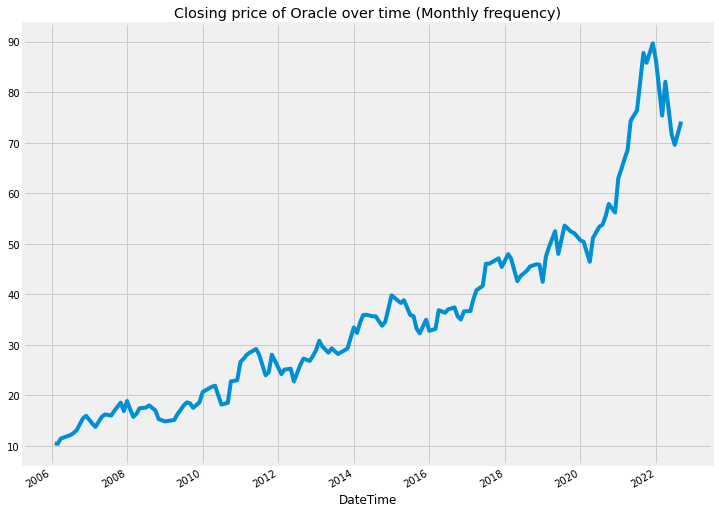

In [ ]:
oracle["Close"].asfreq('M').interpolate().plot() # asfreq method is used to convert a time series to a specified frequency.
                                                 # Here it is monthly frequency. Also using interpolate() to fix the gaps between the timeseries
plt.title('Closing price of Oracle over time (Monthly frequency)')
plt.show()

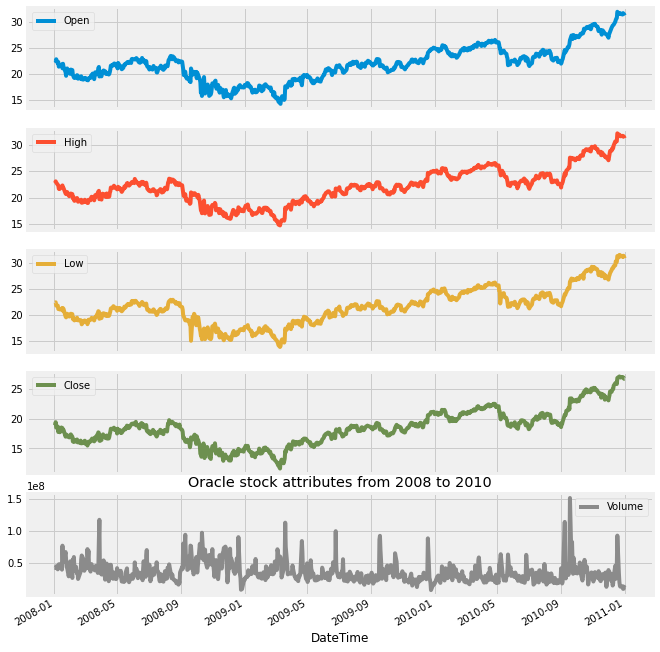

In [ ]:
oracle['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Oracle stock attributes from 2008 to 2010')
plt.savefig('Oracle.png')
plt.show()

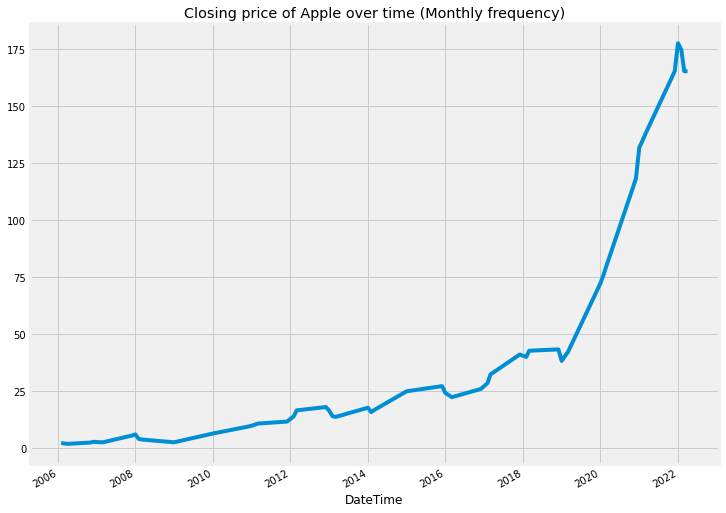

In [ ]:
apple["Close"].asfreq('M').interpolate().plot() # asfreq method is used to convert a time series to a specified frequency.
                                                 # Here it is monthly frequency. Also using interpolate() to fix the gaps between the timeseries
plt.title('Closing price of Apple over time (Monthly frequency)')
plt.show()

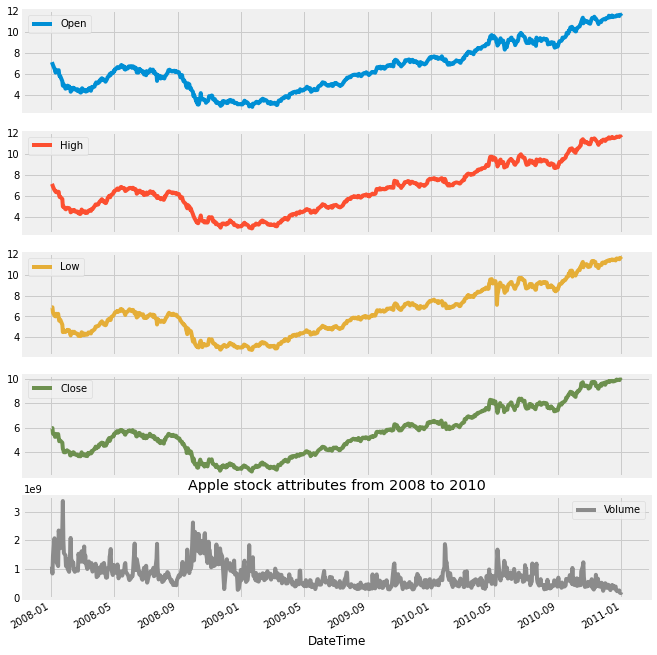

In [ ]:
apple['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Apple stock attributes from 2008 to 2010')
plt.savefig('Apple.png')
plt.show()

In [ ]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [ ]:
# Creating a period
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [ ]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

True

In [ ]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [ ]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

In [ ]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

In [ ]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

year  month  day
0  2015      2    4
1  2016      3    5

In [ ]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [ ]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

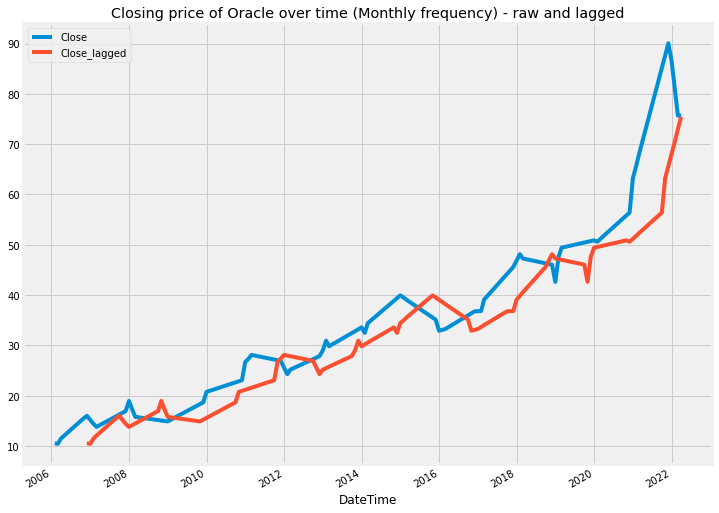

In [ ]:
oracle["Close"].asfreq('M').interpolate().plot(legend=True)
shifted = oracle["Close"].asfreq('M').interpolate().shift(10).plot(legend=True)
shifted.legend(['Close','Close_lagged'])
plt.title('Closing price of Oracle over time (Monthly frequency) - raw and lagged')
plt.show()

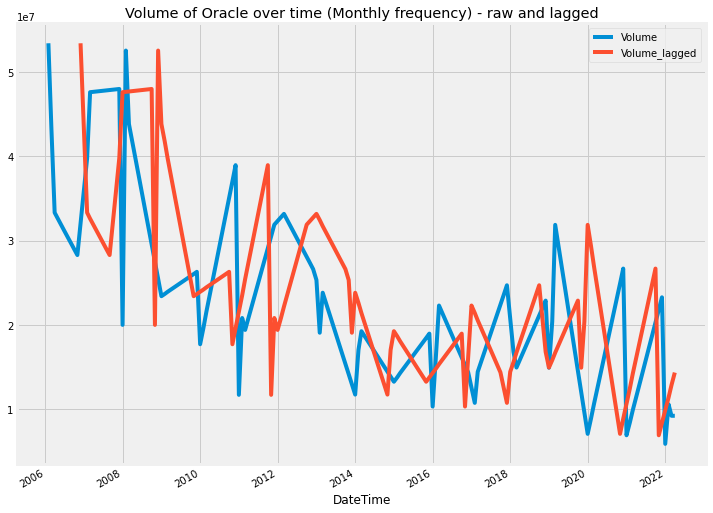

In [ ]:
oracle["Volume"].asfreq('M').interpolate().plot(legend=True)
shifted = oracle["Volume"].asfreq('M').interpolate().shift(10).plot(legend=True)
shifted.legend(['Volume','Volume_lagged'])
plt.title('Volume of Oracle over time (Monthly frequency) - raw and lagged')
plt.show()

In [ ]:
# Shape before resampling(downsampling)
oracle.shape

(4110, 6)

In [ ]:
# We downsample from hourly to 3 day frequency aggregated using mean
oracle_resampled = oracle.resample('3D').mean()
oracle_resampled.head()

Open       High        Low      Close        Volume
DateTime                                                        
2006-01-03  12.47  12.833333  12.453334  10.642727  5.504773e+07
2006-01-06  12.80  13.150000  12.750000  11.020723  9.506760e+07
2006-01-09  12.82  12.860000  12.623333  10.667927  5.096383e+07
2006-01-12  12.61  12.640000  12.425000  10.512527  3.849840e+07
2006-01-15  12.46  12.540000  12.400000  10.449527  2.259370e+07

In [ ]:
# Shape after resampling(downsampling)
oracle_resampled.shape

(1987, 5)

Much less rows are left. Now, we will upsample from 3 day frequency to daily frequency

In [ ]:
oracle_resampled = oracle.resample('D').pad()
oracle_resampled.head()

Open   High    Low      Close      Volume  Name
DateTime                                                    
2006-01-03    NaN    NaN    NaN        NaN         NaN   NaN
2006-01-04  12.23  12.80  12.22  10.583928  56073800.0  ORCL
2006-01-05  12.56  12.78  12.54  10.600727  56412300.0  ORCL
2006-01-06  12.62  12.92  12.60  10.743526  52657100.0  ORCL
2006-01-07  12.80  13.15  12.75  11.020723  95067600.0  ORCL

In [ ]:
# Shape after resampling(upsampling)
oracle_resampled.shape

(5961, 6)

Again an increase in number of rows. Resampling is cool when used properly.

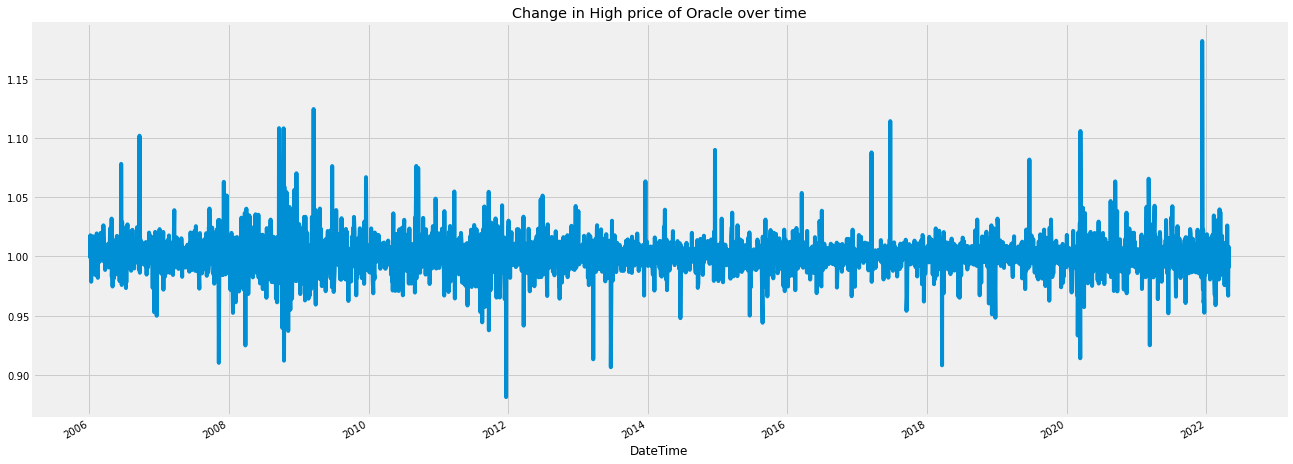

In [ ]:
oracle['Change'] = oracle.High.div(oracle.High.shift())
oracle['Change'].plot(figsize=(20,8))
_ = plt.title('Change in High price of Oracle over time')

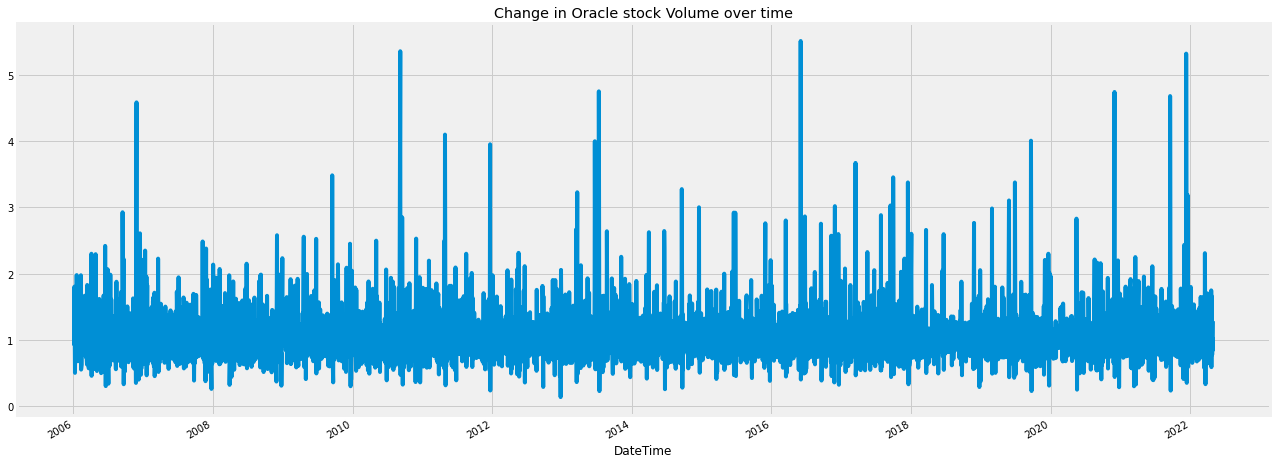

In [ ]:
oracle['Volume_Change'] = oracle.Volume.div(oracle.Volume.shift())
oracle['Volume_Change'].plot(figsize=(20,8))
_ = plt.title('Change in Oracle stock Volume over time')

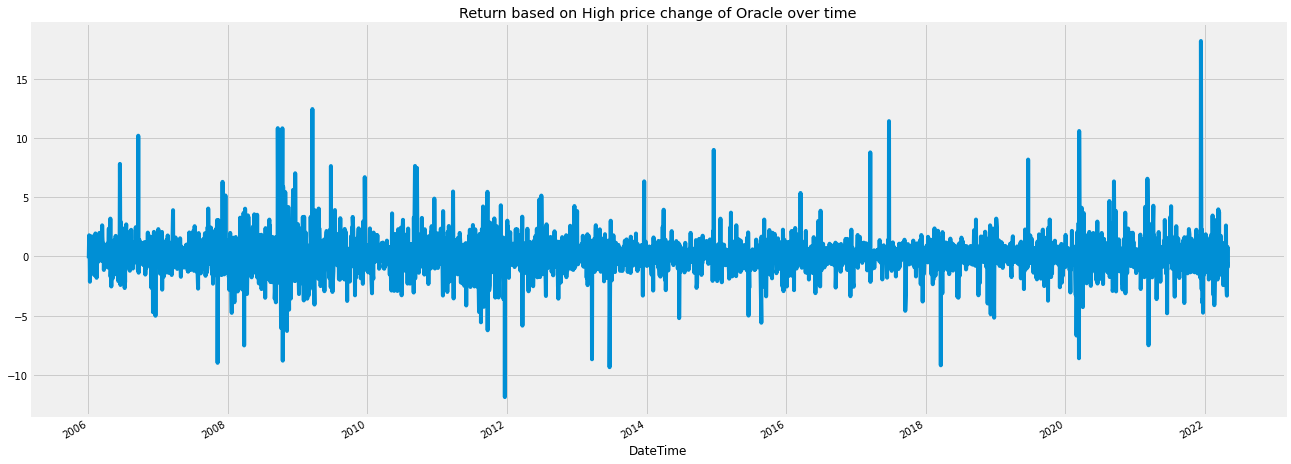

In [ ]:
oracle['Return'] = oracle.Change.sub(1).mul(100)
oracle['Return'].plot(figsize=(20,8))
_ = plt.title('Return based on High price change of Oracle over time')

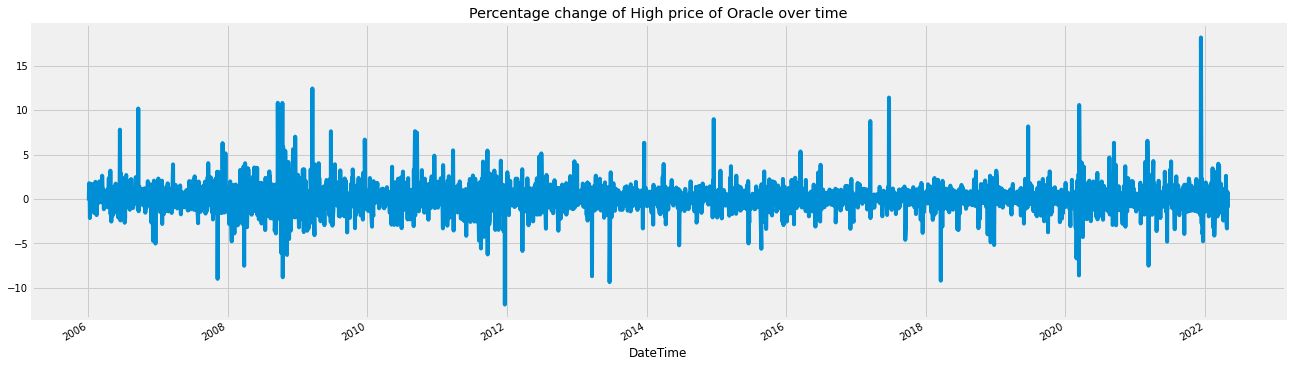

In [ ]:
oracle.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns
_ = plt.title('Percentage change of High price of Oracle over time')

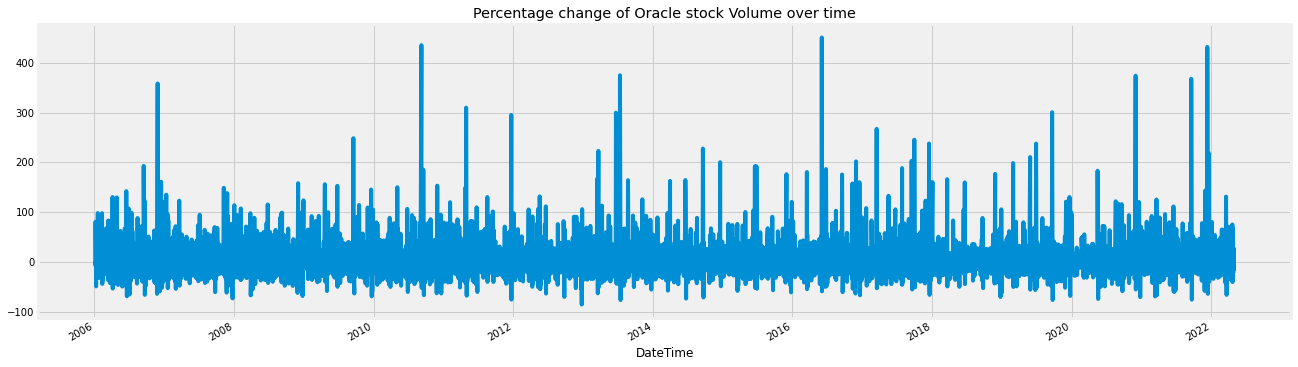

In [ ]:
oracle.Volume.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns
_ = plt.title('Percentage change of Oracle stock Volume over time')

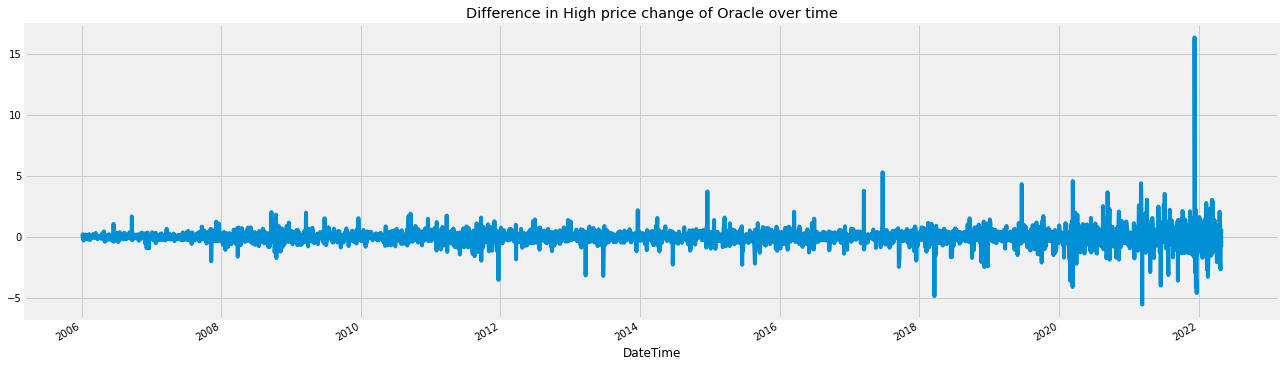

In [ ]:
oracle.High.diff().plot(figsize=(20,6))
_ = plt.title('Difference in High price change of Oracle over time')

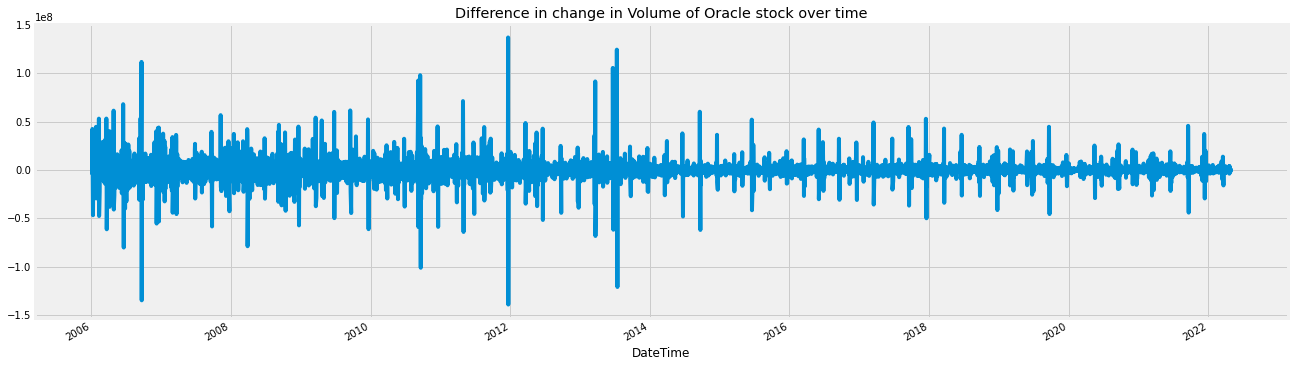

In [ ]:
oracle.Volume.diff().plot(figsize=(20,6))
_ = plt.title('Difference in change in Volume of Oracle stock over time')

## <a id='2.4'>2.4 Comparing two or more time series</a>

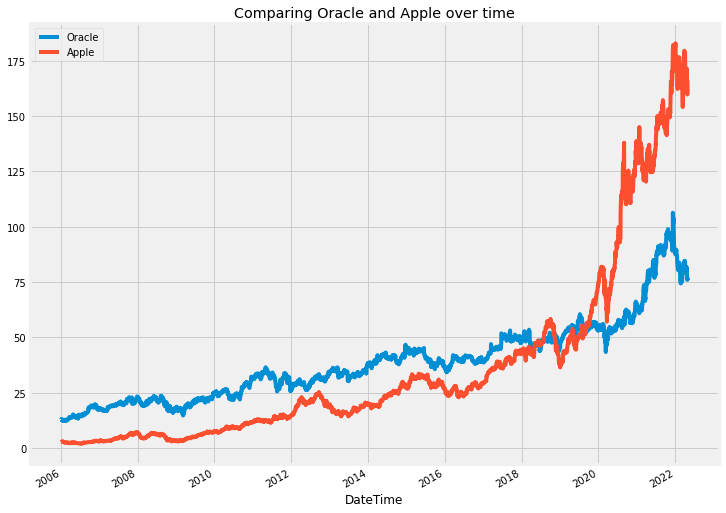

In [ ]:
# Plotting before normalization
oracle.High.plot()
apple.High.plot()
plt.legend(['Oracle','Apple'])
_ = plt.title('Comparing Oracle and Apple over time')
plt.show()

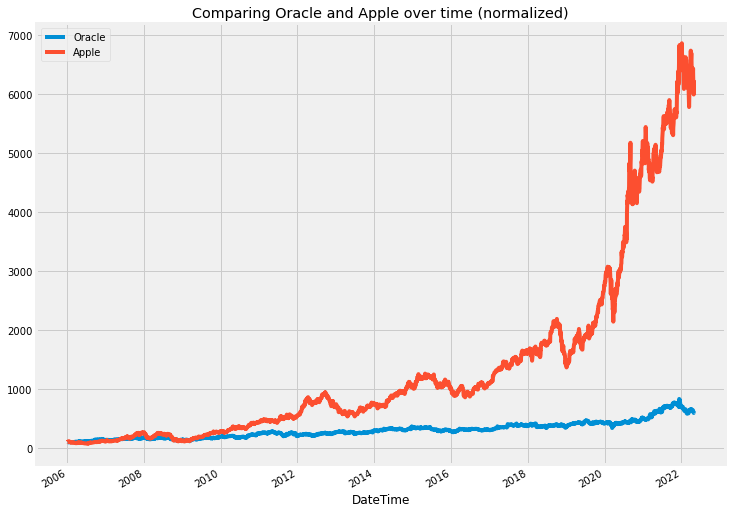

In [ ]:
# Normalizing and comparison
# Both stocks start from 100
normalized_oracle = oracle.High.div(oracle.High.iloc[0]).mul(100)
normalized_apple = apple.High.div(apple.High.iloc[0]).mul(100)
normalized_oracle.plot()
normalized_apple.plot()
_ = plt.title('Comparing Oracle and Apple over time (normalized)')
plt.legend(['Oracle','Apple'])
plt.show()

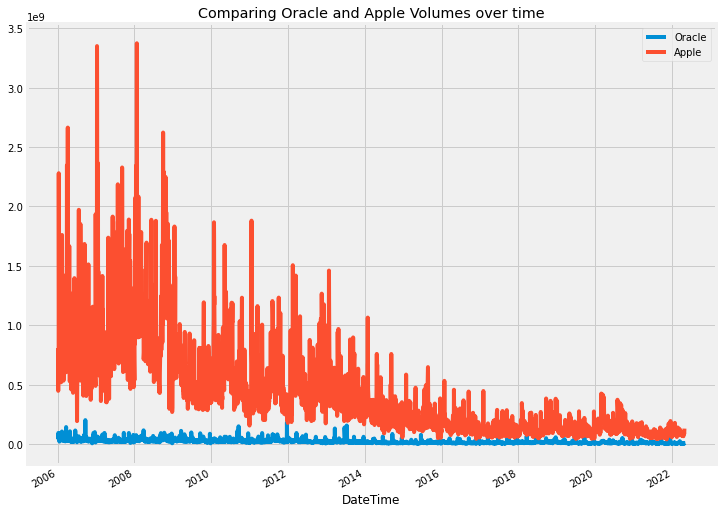

In [ ]:
# Plotting before normalization
oracle.Volume.plot()
apple.Volume.plot()
plt.legend(['Oracle','Apple'])
_ = plt.title('Comparing Oracle and Apple Volumes over time')
plt.show()

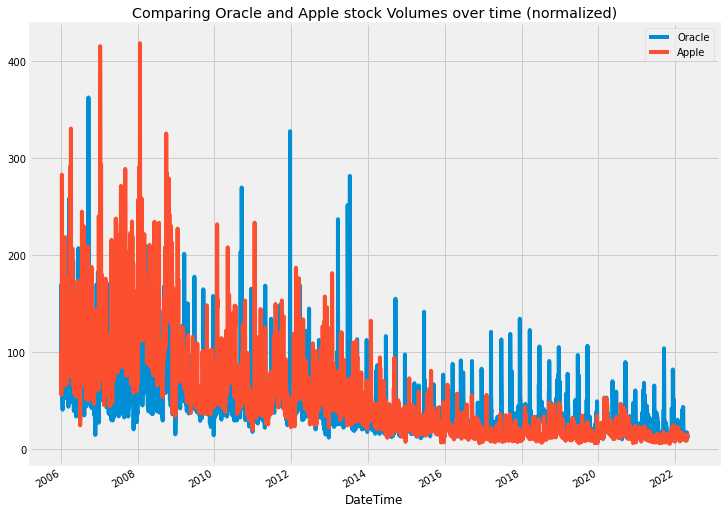

In [ ]:
# Normalizing and comparison
# Both stocks start from 100
normalized_oracle = oracle.Volume.div(oracle.Volume.iloc[0]).mul(100)
normalized_apple = apple.Volume.div(apple.Volume.iloc[0]).mul(100)
normalized_oracle.plot()
normalized_apple.plot()
_ = plt.title('Comparing Oracle and Apple stock Volumes over time (normalized)')
plt.legend(['Oracle','Apple'])
plt.show()

You can clearly see how Apple outperforms Oracle over time.

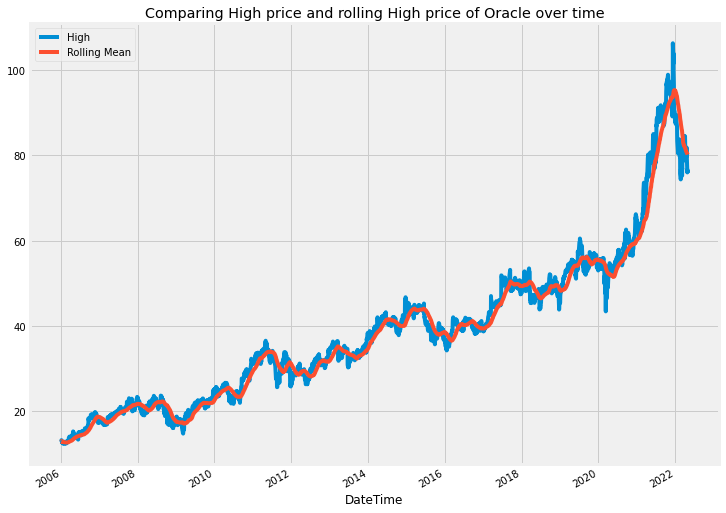

In [ ]:
# Rolling window functions
rolling_oracle = oracle.High.rolling('90D').mean()
oracle.High.plot()
rolling_oracle.plot()
_ = plt.title('Comparing High price and rolling High price of Oracle over time')
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of Oracle stocks
plt.show()

Now, observe that rolling mean plot is a smoother version of the original plot.

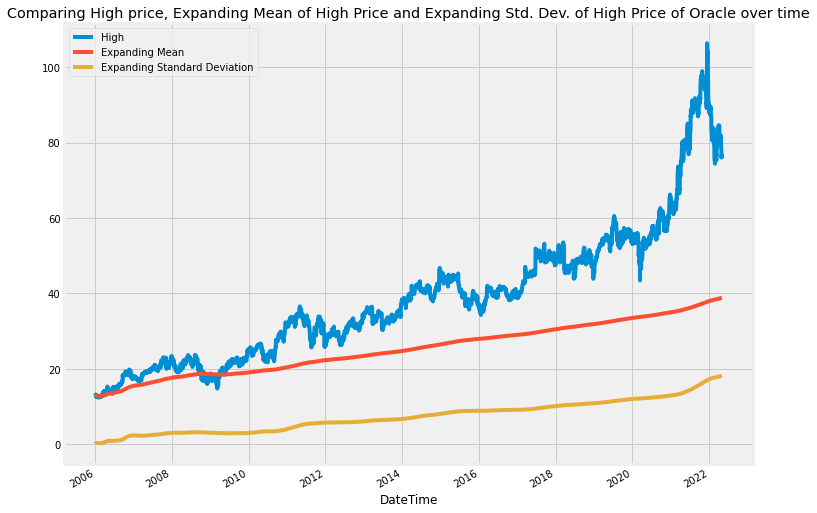

In [ ]:
# Expanding window functions
oracle_mean = oracle.High.expanding().mean()
oracle_std = oracle.High.expanding().std()
oracle.High.plot()
oracle_mean.plot()
oracle_std.plot()
_ = plt.title('Comparing High price, Expanding Mean of High Price and Expanding Std. Dev. of High Price of Oracle over time')
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

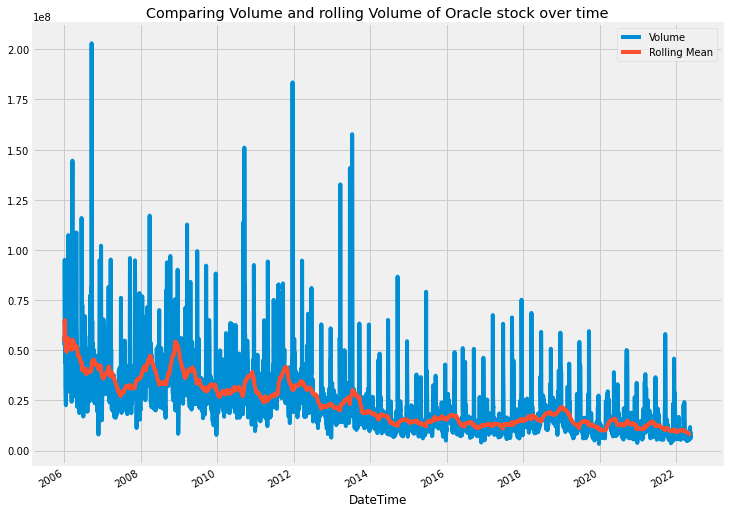

In [ ]:
# Rolling window functions
rolling_oracle = oracle.Volume.rolling('90D').mean()
oracle.Volume.plot()
rolling_oracle.plot()
_ = plt.title('Comparing Volume and rolling Volume of Oracle stock over time')
plt.legend(['Volume','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of Oracle stocks
plt.show()

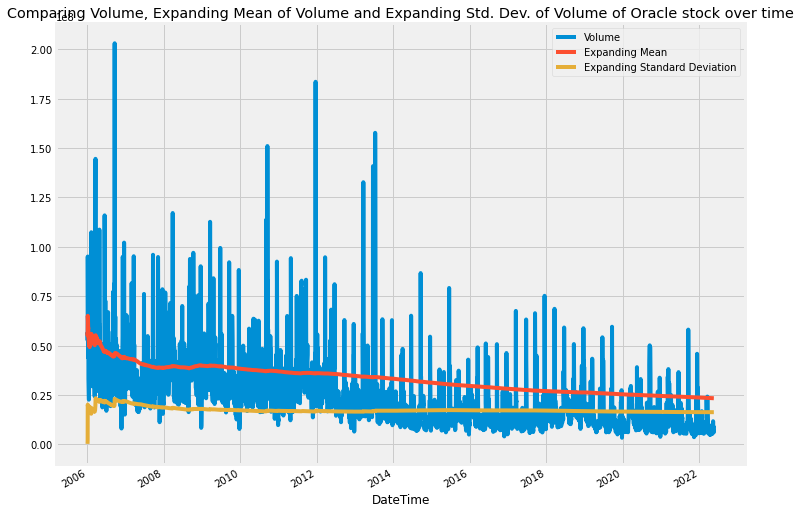

In [ ]:
# Expanding window functions
oracle_mean = oracle.Volume.expanding().mean()
oracle_std = oracle.Volume.expanding().std()
oracle.Volume.plot()
oracle_mean.plot()
oracle_std.plot()
_ = plt.title('Comparing Volume, Expanding Mean of Volume and Expanding Std. Dev. of Volume of Oracle stock over time')
plt.legend(['Volume','Expanding Mean','Expanding Standard Deviation'])
plt.show()

In [ ]:
# OHLC chart of June 2008
trace = go.Ohlc(x=oracle['06-2008'].index,
                open=oracle['06-2008'].Open,
                high=oracle['06-2008'].High,
                low=oracle['06-2008'].Low,
                close=oracle['06-2008'].Close)
data = [trace]
print('OHLC price chart of Oracle for June 2008')
iplot(data, filename='simple_ohlc')

OHLC price chart of Oracle for June 2008


In [ ]:
# OHLC chart of 2008
trace = go.Ohlc(x=oracle['2008'].index,
                open=oracle['2008'].Open,
                high=oracle['2008'].High,
                low=oracle['2008'].Low,
                close=oracle['2008'].Close)
data = [trace]
print('OHLC price chart of Oracle for 2008')
iplot(data, filename='simple_ohlc')

OHLC price chart of Oracle for 2008


In [ ]:
# OHLC chart of 2008
trace = go.Ohlc(x=oracle.index,
                open=oracle.Open,
                high=oracle.High,
                low=oracle.Low,
                close=oracle.Close)
data = [trace]
print('OHLC price chart of Oracle')
iplot(data, filename='simple_ohlc')

OHLC price chart of Oracle


In [ ]:
# Candlestick chart of march 2008
trace = go.Candlestick(x=oracle['03-2008'].index,
                open=oracle['03-2008'].Open,
                high=oracle['03-2008'].High,
                low=oracle['03-2008'].Low,
                close=oracle['03-2008'].Close)
data = [trace]
print('OHLC price chart (Candlestick) of Oracle for March 2008')
iplot(data, filename='simple_candlestick')

OHLC price chart (Candlestick) of Oracle for March 2008


In [ ]:
# Candlestick chart of 2008
trace = go.Candlestick(x=oracle['2008'].index,
                open=oracle['2008'].Open,
                high=oracle['2008'].High,
                low=oracle['2008'].Low,
                close=oracle['2008'].Close)
data = [trace]
print('OHLC price chart (Candlestick) of Oracle for 2008')
iplot(data, filename='simple_candlestick')

OHLC price chart (Candlestick) of Oracle for 2008


In [ ]:
# Candlestick chart of 2006-2018
trace = go.Candlestick(x=oracle.index,
                open=oracle.Open,
                high=oracle.High,
                low=oracle.Low,
                close=oracle.Close)
data = [trace]
print('OHLC price chart (Candlestick) of Oracle')
iplot(data, filename='simple_candlestick')

OHLC price chart (Candlestick) of Oracle


## Autocorrelation

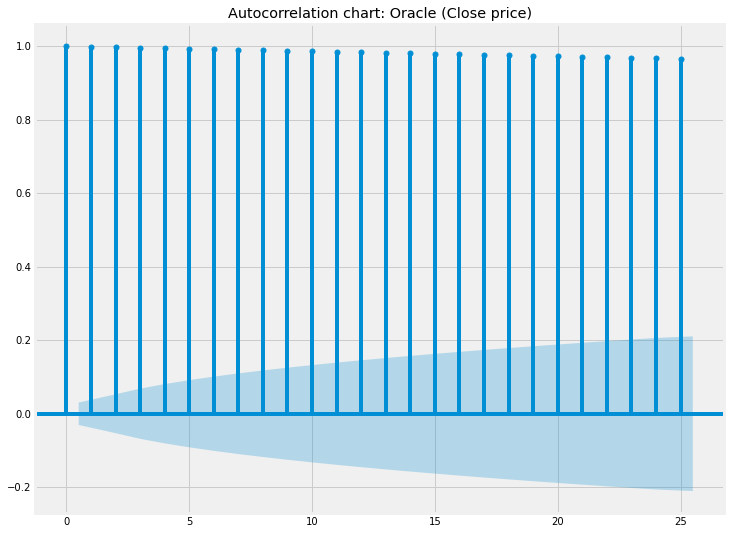

In [ ]:
# Autocorrelation of Closing price of Oracle
plot_acf(oracle["Close"],lags=25,title="Autocorrelation chart: Oracle (Close price)")
plt.show()

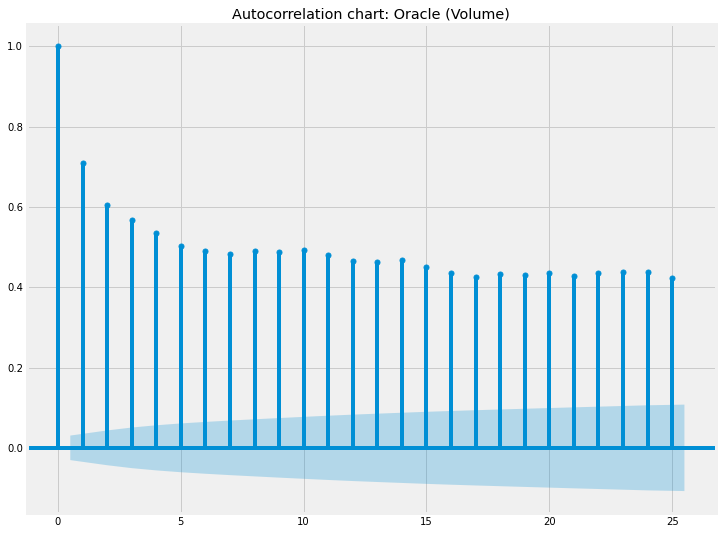

In [ ]:
# Autocorrelation of Volume of Oracle stock
plot_acf(oracle["Volume"],lags=25,title="Autocorrelation chart: Oracle (Volume)")
plt.show()

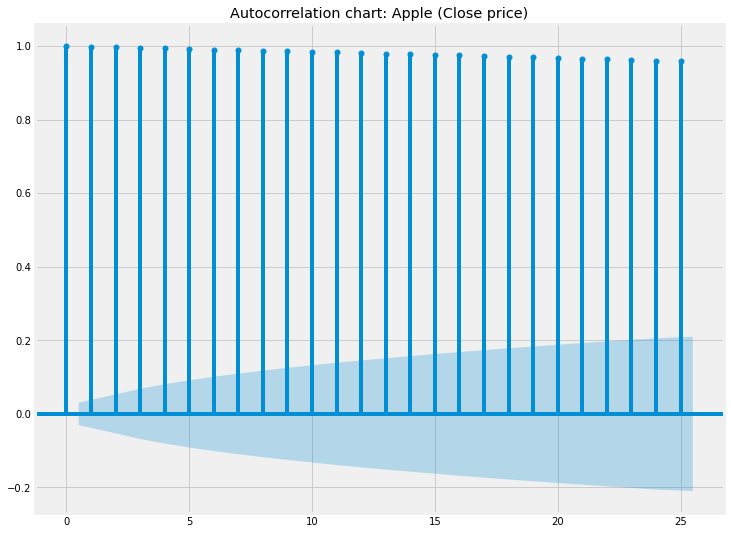

In [ ]:
# Autocorrelation of Closing price of Apple
plot_acf(apple["Close"],lags=25,title="Autocorrelation chart: Apple (Close price)")
plt.show()

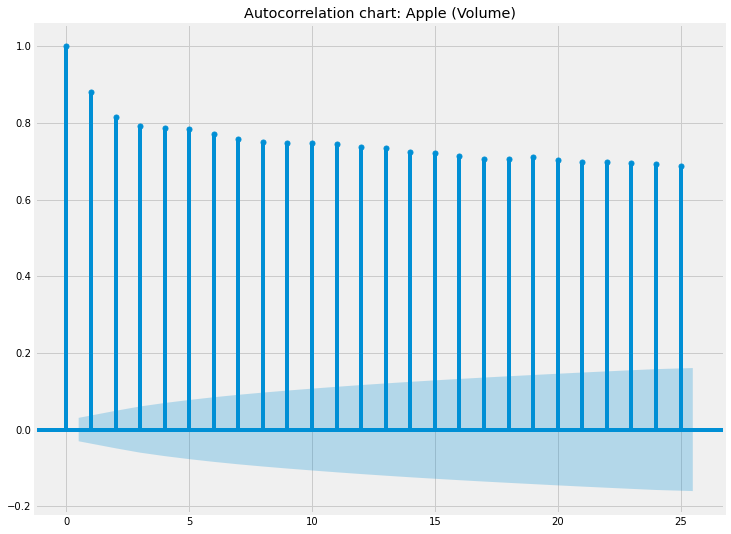

In [ ]:
# Autocorrelation of Volume of Apple stock
plot_acf(apple["Volume"],lags=25,title="Autocorrelation chart: Apple (Volume)")
plt.show()

 As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.

## Partial Autocorrelation

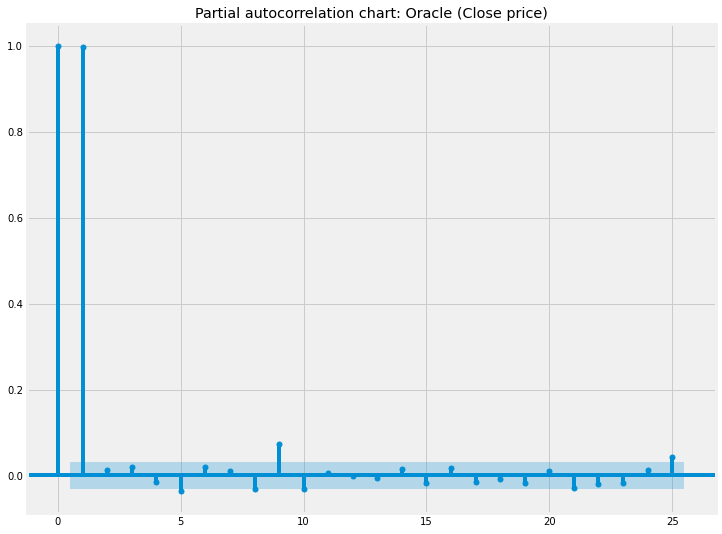

In [ ]:
# Partial Autocorrelation of Closing price of Oracle
plot_pacf(oracle["Close"],lags=25, title="Partial autocorrelation chart: Oracle (Close price)")
plt.show()

Though it is statistically signficant, partial autocorrelation after first 2 lags is very low.

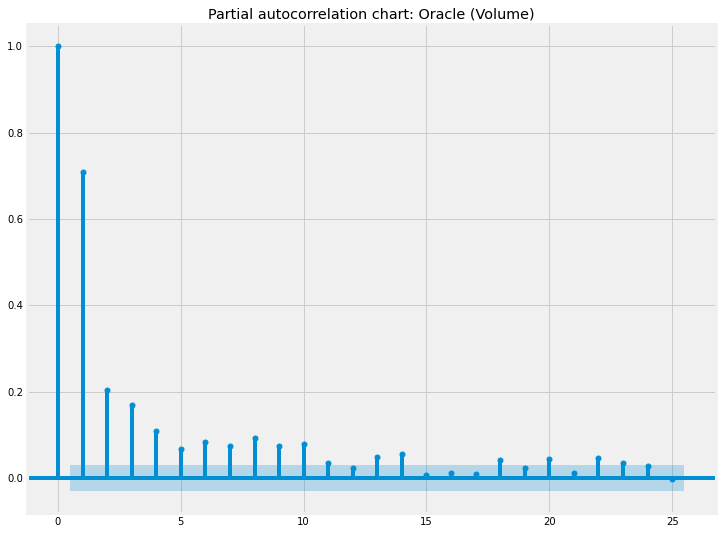

In [ ]:
# Partial Autocorrelation of Volume of Oracle stock
plot_pacf(oracle["Volume"],lags=25, title="Partial autocorrelation chart: Oracle (Volume)")
plt.show()

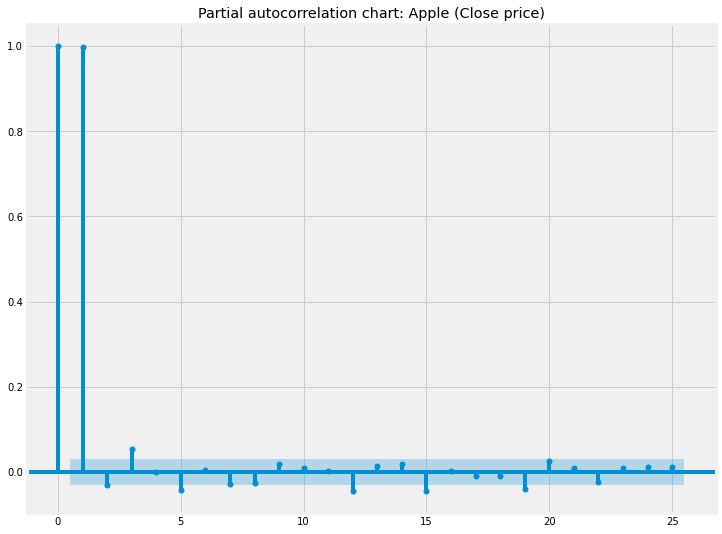

In [ ]:
# Partial Autocorrelation of closing price of Apple
plot_pacf(apple["Close"],lags=25, title="Partial autocorrelation chart: Apple (Close price)")
plt.show()

Here, only 0th and 1st lag are statistically significant.

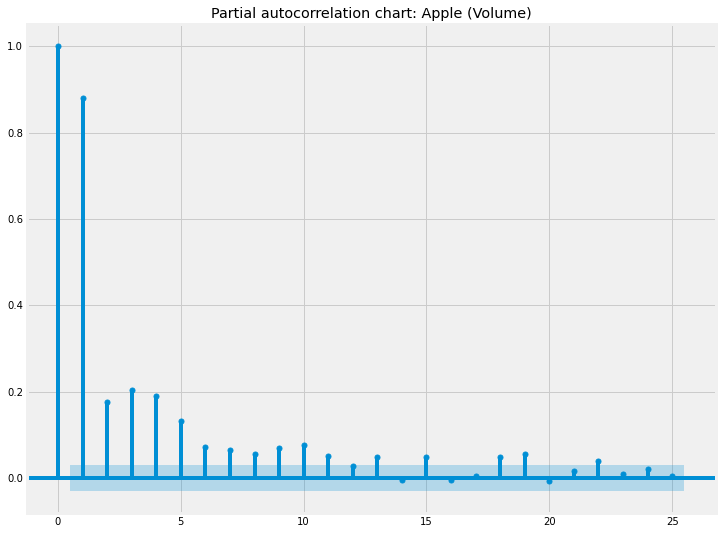

In [ ]:
# Partial Autocorrelation of Volume of Apple stock
plot_pacf(apple["Volume"],lags=25, title="Partial autocorrelation chart: Apple (Volume)")
plt.show()

# <a id='3'>3. Time series decomposition and Random walks</a>

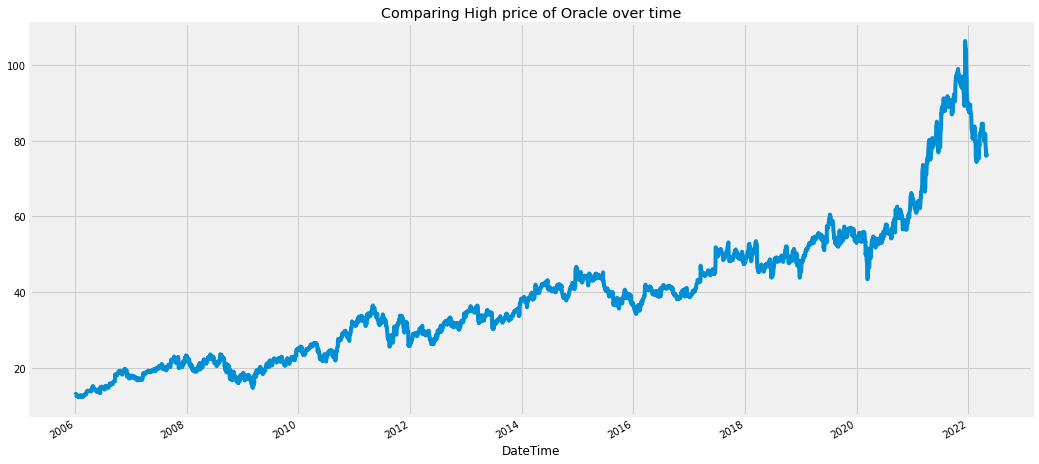

In [ ]:
# Let's take Oracle stocks High for this
oracle["High"].plot(figsize=(16,8))
_ = plt.title('Comparing High price of Oracle over time')

Decomposing closing price of Oracle over time


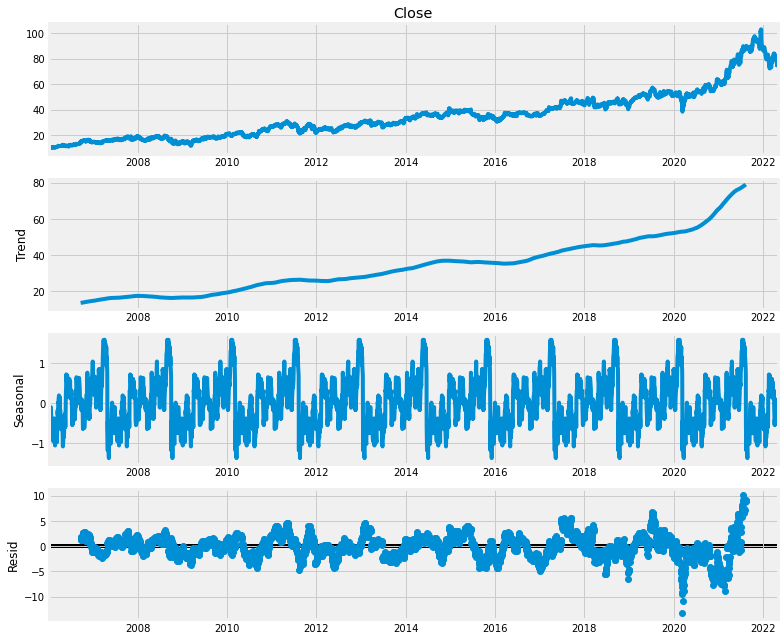

In [ ]:
# Now, for decomposition...
print('Decomposing closing price of Oracle over time')
decomposed_oracle_close = sm.tsa.seasonal_decompose(oracle["Close"],freq=360) # The frequncy is annual
figure = decomposed_oracle_close.plot()
plt.show()

Decomposing volume data of Oracle over time


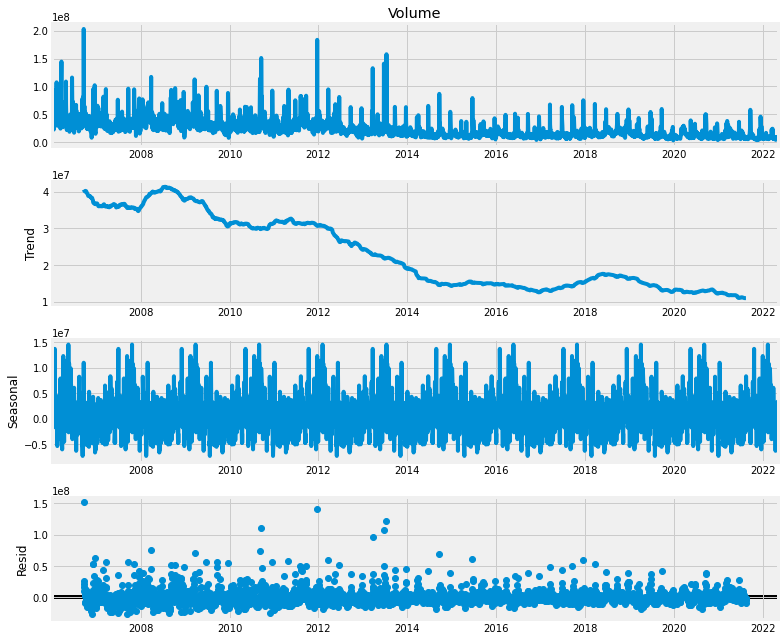

In [ ]:
# Now, for decomposition...
print('Decomposing volume data of Oracle over time')
decomposed_oracle_volume = sm.tsa.seasonal_decompose(oracle["Volume"],freq=360) # The frequncy is annual
figure = decomposed_oracle_volume.plot()
plt.show()

* There is clearly an upward trend in the above plot.
* You can also see the uniform seasonal change.
* Non-uniform noise that represent outliers and missing values

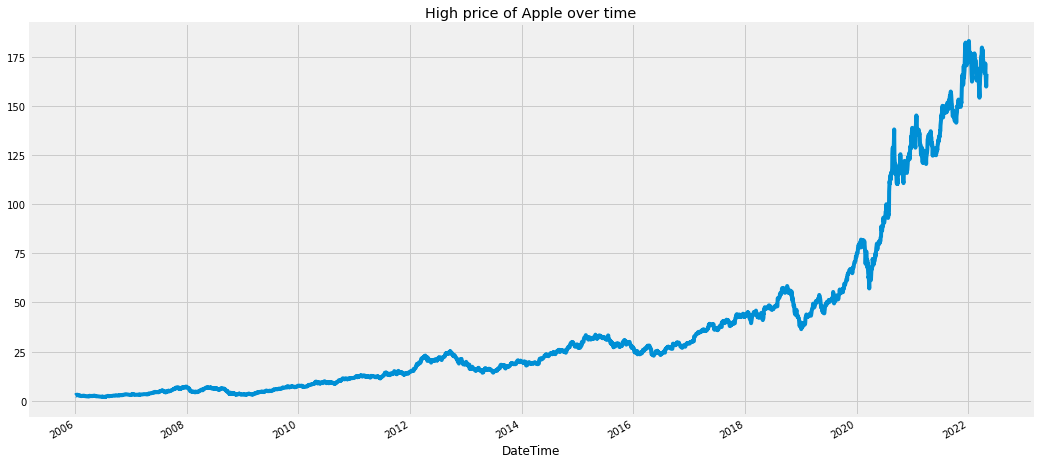

In [ ]:
# Let's take Apple stocks High for this
apple["High"].plot(figsize=(16,8))
_ = plt.title('High price of Apple over time')

Decomposing closing price of Apple over time


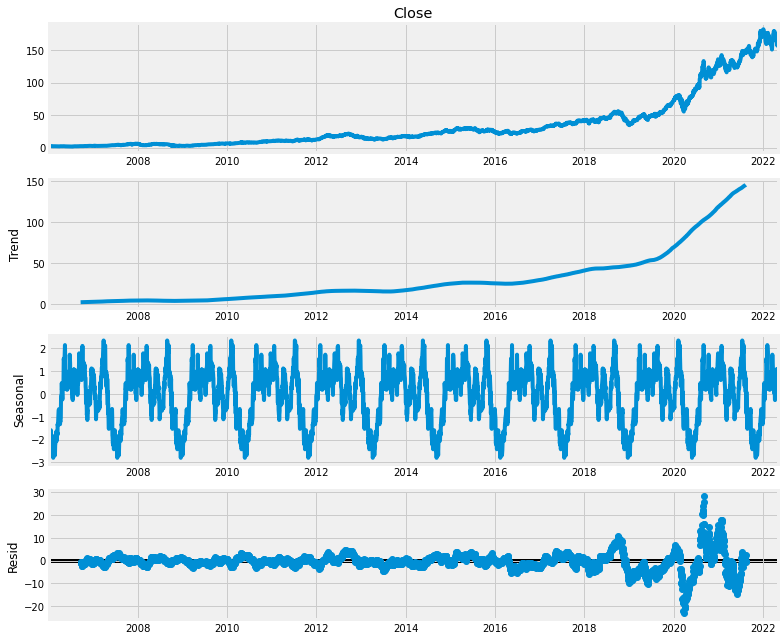

In [ ]:
# Now, for decomposition...
print('Decomposing closing price of Apple over time')
decomposed_apple_close = sm.tsa.seasonal_decompose(apple["Close"],freq=360) # The frequncy is annual
figure = decomposed_apple_close.plot()
plt.show()

Decomposing volume data of Apple over time


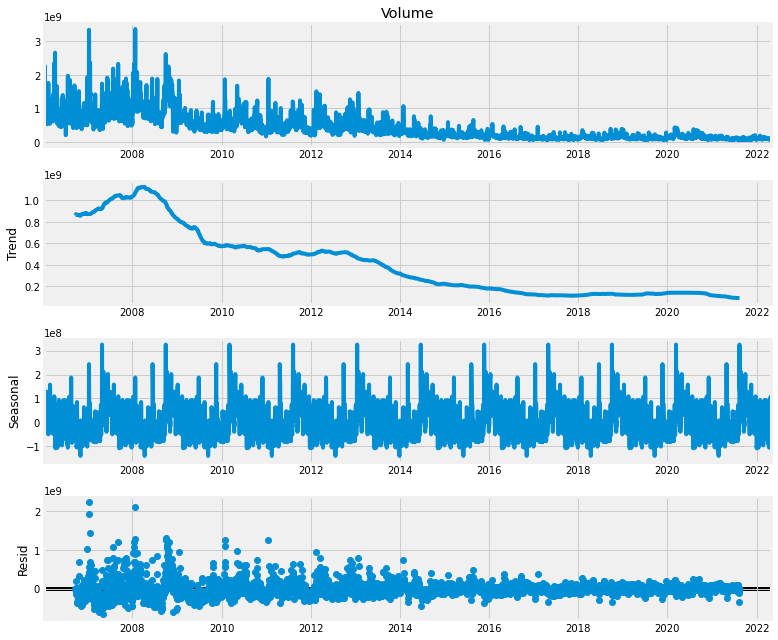

In [ ]:
# Now, for decomposition...
print('Decomposing volume data of Apple over time')
decomposed_apple_volume = sm.tsa.seasonal_decompose(apple["Volume"],freq=360) # The frequncy is annual
figure = decomposed_apple_volume.plot()
plt.show()

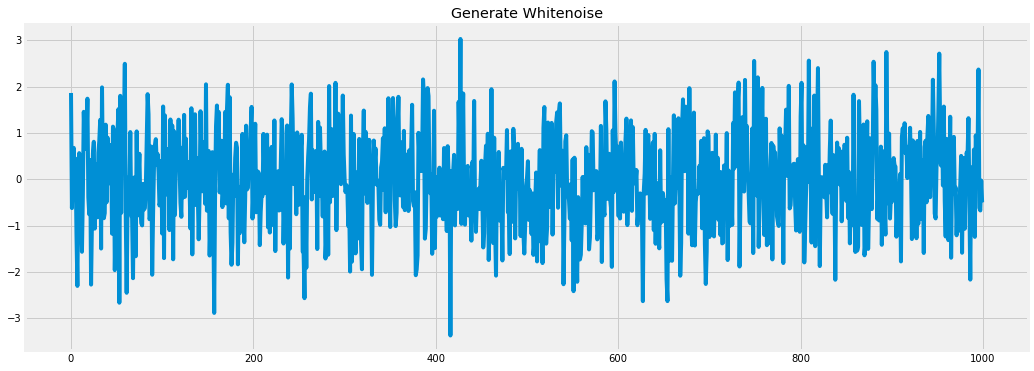

In [ ]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
_ = plt.title('Generate Whitenoise')
# loc is mean, scale is variance
plt.plot(white_noise)

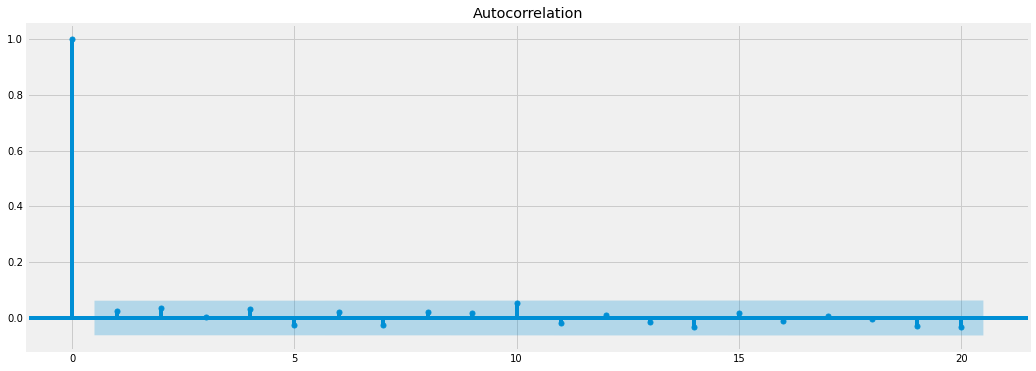

In [ ]:
# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

See how all lags are statistically insigficant as they lie inside the confidence interval(shaded portion).

In [ ]:
# Augmented Dickey-Fuller test on volume of Oracle and Apple stocks
adf = adfuller(oracle["Volume"])
print("p-value of Oracle: {}".format(float(adf[1])))
adf = adfuller(apple["Volume"])
print("p-value of Apple: {}".format(float(adf[1])))

p-value of Oracle: 0.0001524657819261941
p-value of Apple: 0.03217067616984904


### Generating a random walk

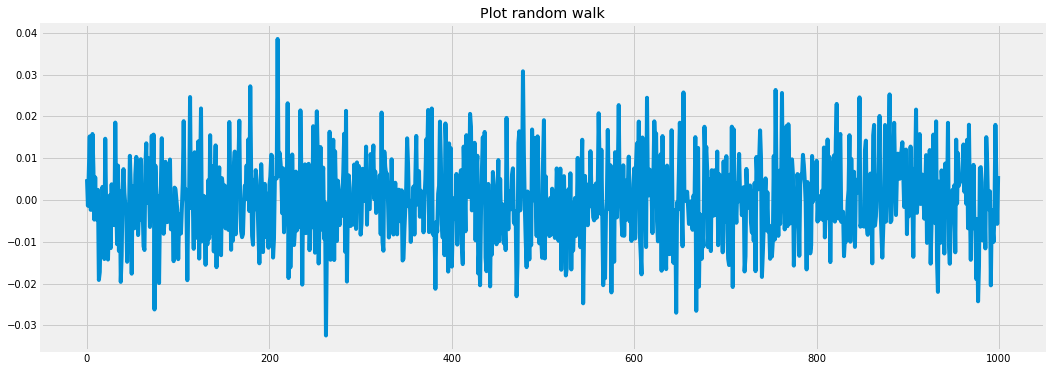

In [ ]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
_ = plt.title('Plot random walk')
plt.plot(random_walk)
plt.show()

In [ ]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
print('Random walk data distribution')
iplot(fig, filename='Basic Distplot')

Random walk data distribution


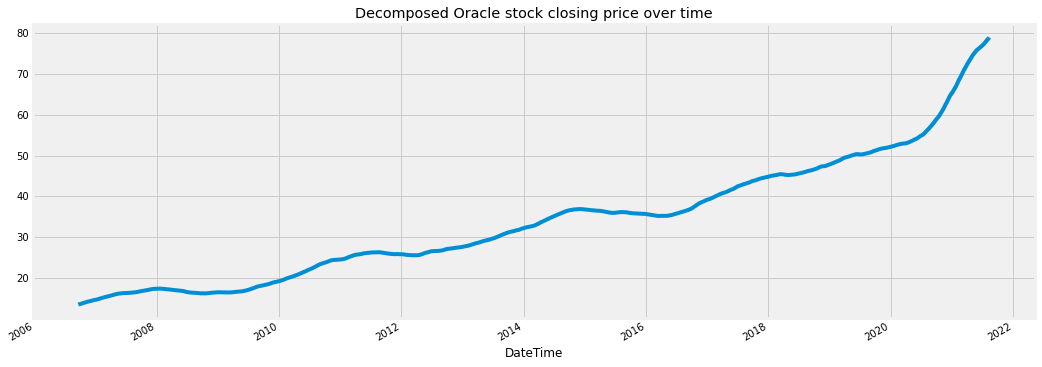

In [ ]:
# The original non-stationary plot
decomposed_oracle_close.trend.plot()
_ = plt.title('Decomposed Oracle stock closing price over time')

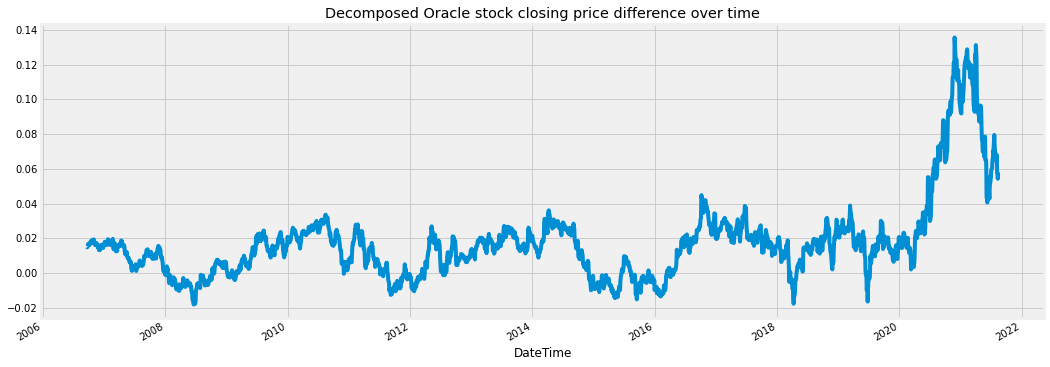

In [ ]:
# The original non-stationary plot
decomposed_oracle_close.trend.diff().plot()
_ = plt.title('Decomposed Oracle stock closing price difference over time')

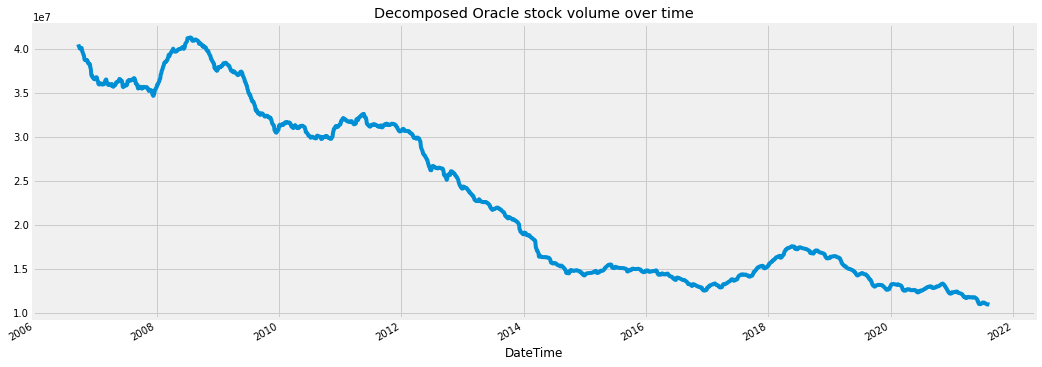

In [ ]:
# The original non-stationary plot
decomposed_oracle_volume.trend.plot()
_ = plt.title('Decomposed Oracle stock volume over time')

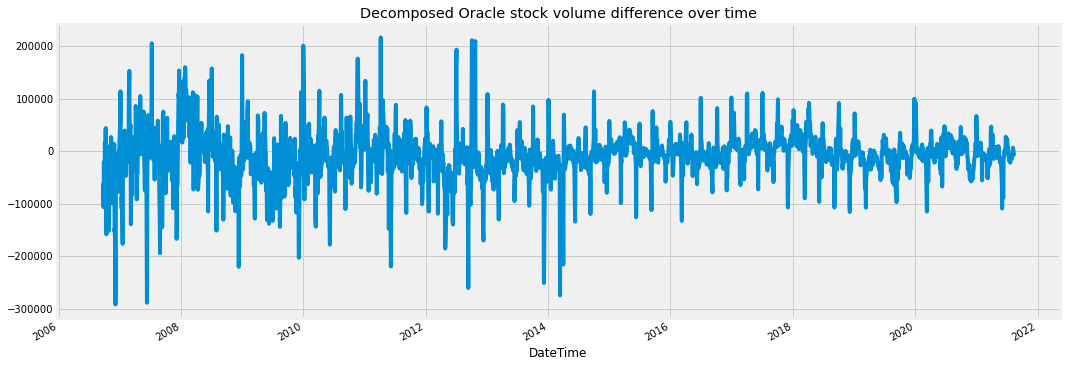

In [ ]:
# The original non-stationary plot
decomposed_oracle_volume.trend.diff().plot()
_ = plt.title('Decomposed Oracle stock volume difference over time')

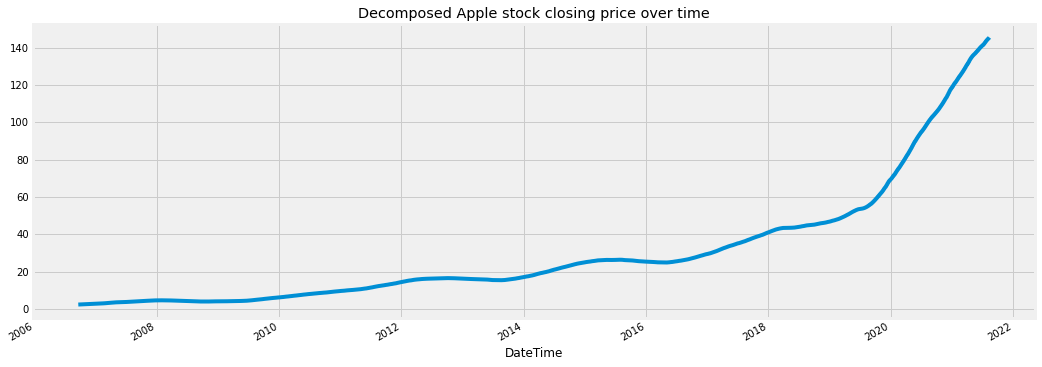

In [ ]:
# The new stationary plot
decomposed_apple_close.trend.plot()
_ = plt.title('Decomposed Apple stock closing price over time')

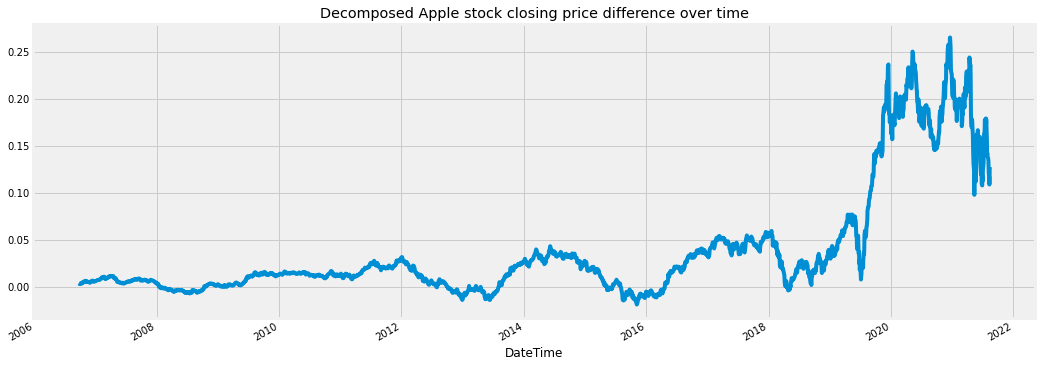

In [ ]:
# The new stationary plot
decomposed_apple_close.trend.diff().plot()
_ = plt.title('Decomposed Apple stock closing price difference over time')

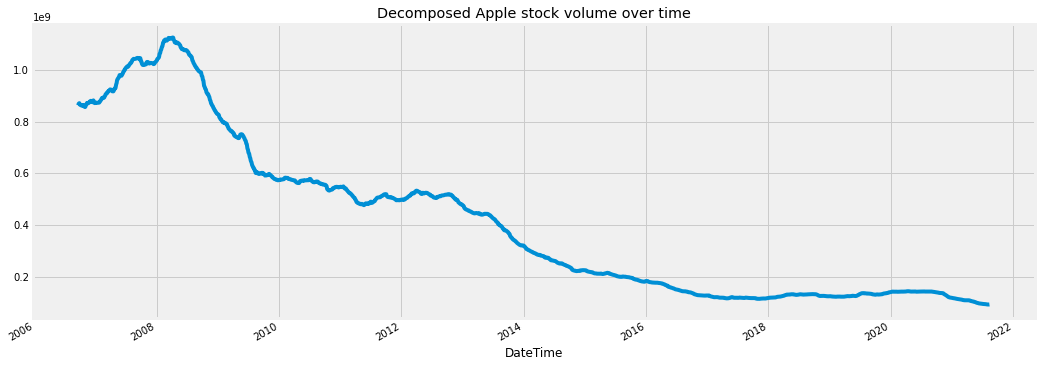

In [ ]:
# The new stationary plot
decomposed_apple_volume.trend.plot()
_ = plt.title('Decomposed Apple stock volume over time')

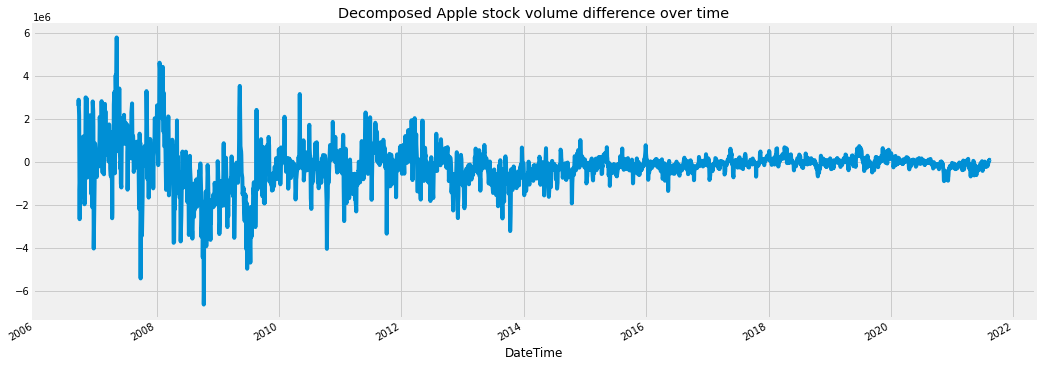

In [ ]:
# The new stationary plot
decomposed_apple_volume.trend.diff().plot()
_ = plt.title('Decomposed Apple stock volume difference over time')

# <a id='4'>4. Modelling using statstools</a>

## Simulating AR(1) model

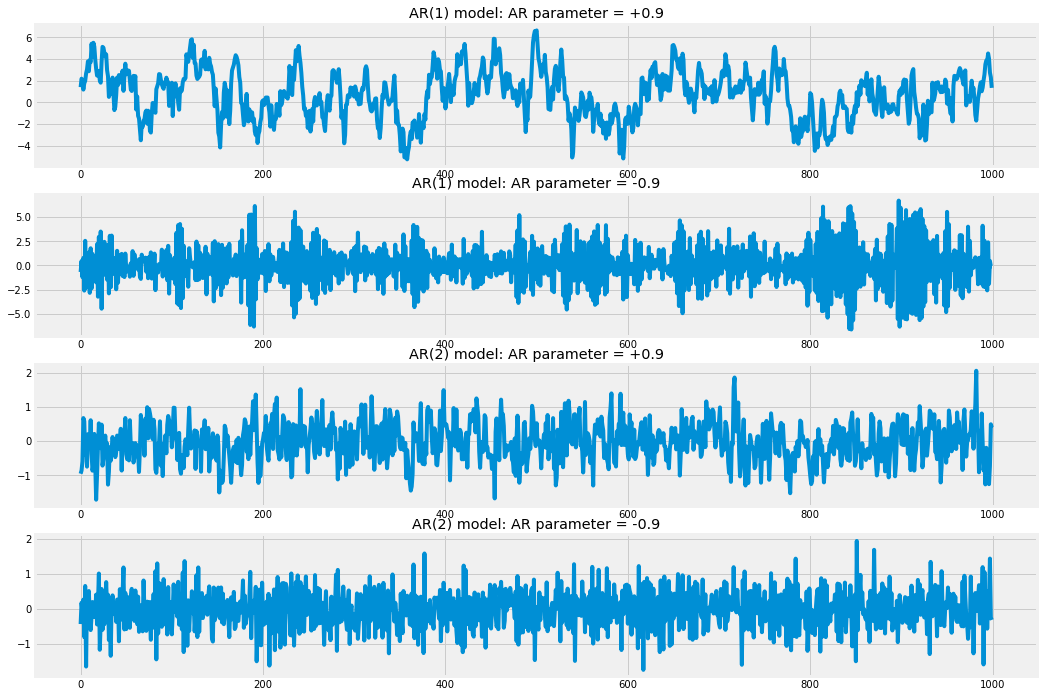

In [ ]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

## Forecasting a simulated model

In [ ]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Mon, 02 May 2022   AIC                           2837.403
Time:                        12:56:53   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

ϕ is around 0.9 which is what we chose as AR parameter in our first simulated model.

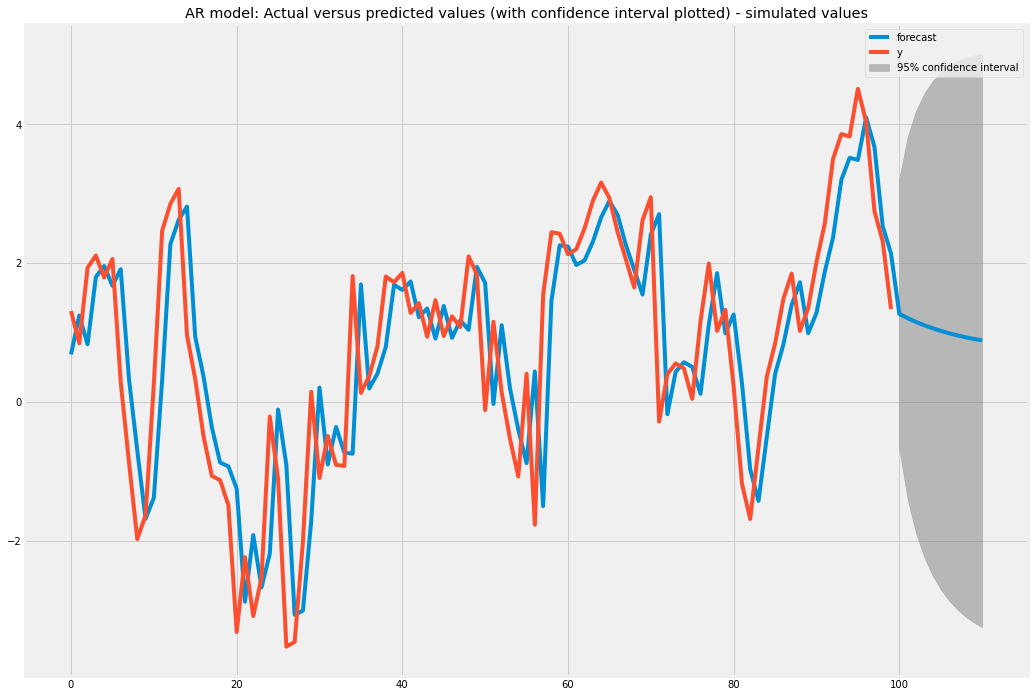

In [ ]:
# Predicting simulated AR(1) model
result.plot_predict(start=900, end=1010)
_ = plt.title('AR model: Actual versus predicted values (with confidence interval plotted) - simulated values')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054481062372.


y is predicted plot. Quite neat!

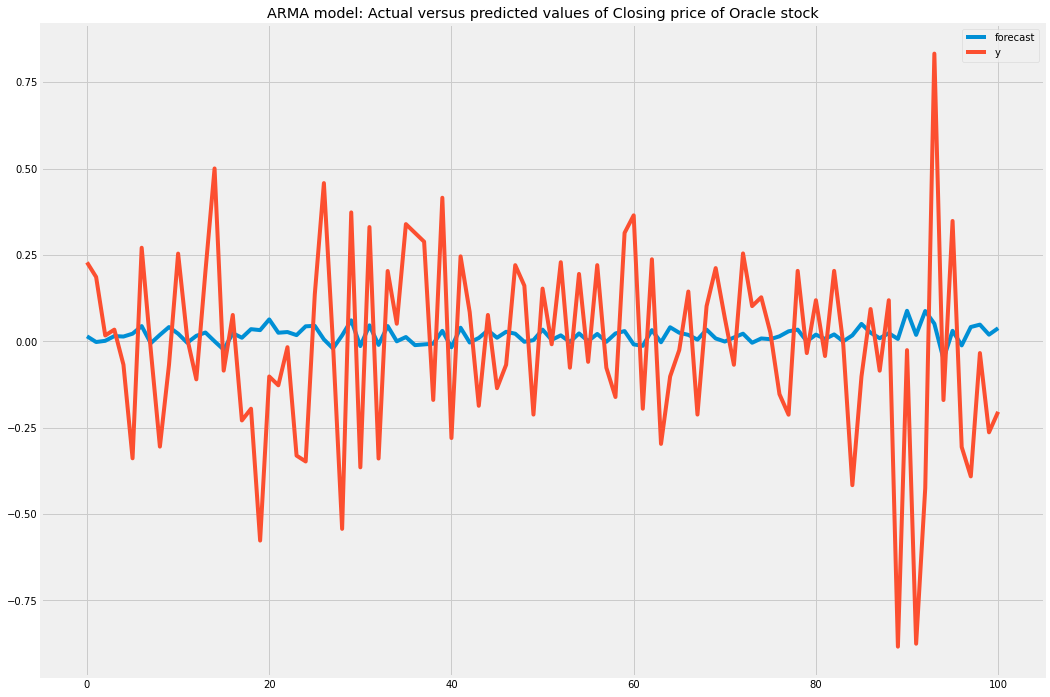

In [ ]:
# Predicting Close price of Oracle
close_price = ARMA(oracle["Close"].diff().iloc[1:].values, order=(1,0))
res = close_price.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of Closing price of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Close"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.751659310636914.


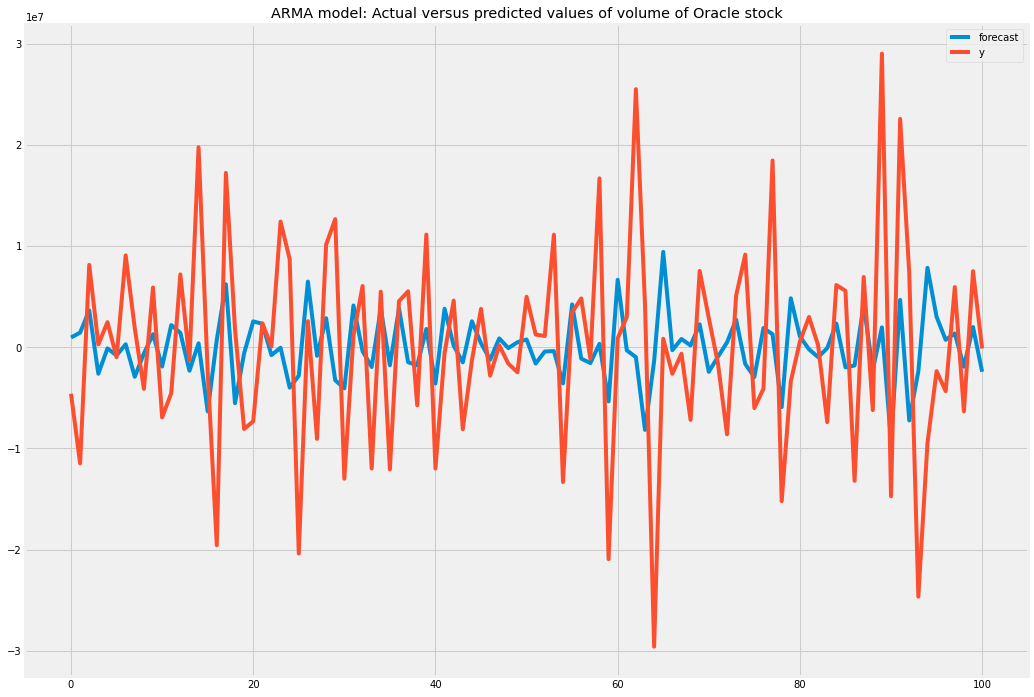

In [ ]:
# Predicting Volume of Oracle
volume = ARMA(oracle["Volume"].diff().iloc[1:].values, order=(1,0))
res = volume.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of volume of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Volume"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 13682916.453458482.


 Not quite impressive. But let's try Apple stocks.

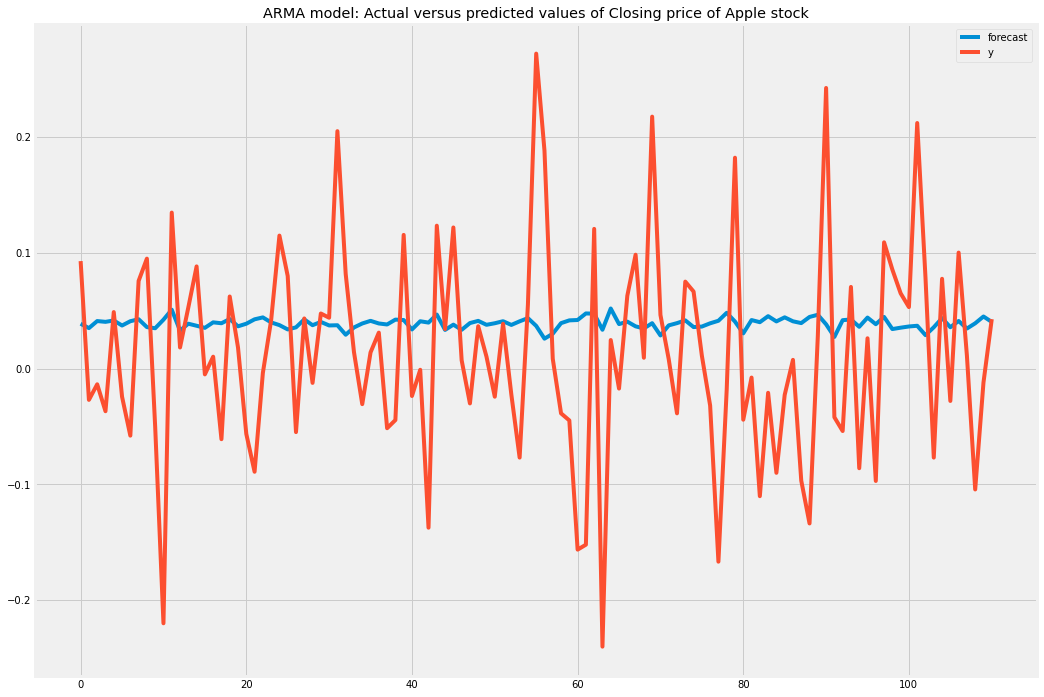

In [ ]:
# Predicting closing prices of Apple
close_price = ARMA(apple["Close"].diff().iloc[1:].values, order=(1,0))
res = close_price.fit()
res.plot_predict(start=900, end=1010)
_ = plt.title('ARMA model: Actual versus predicted values of Closing price of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Close"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.7453294710446388.


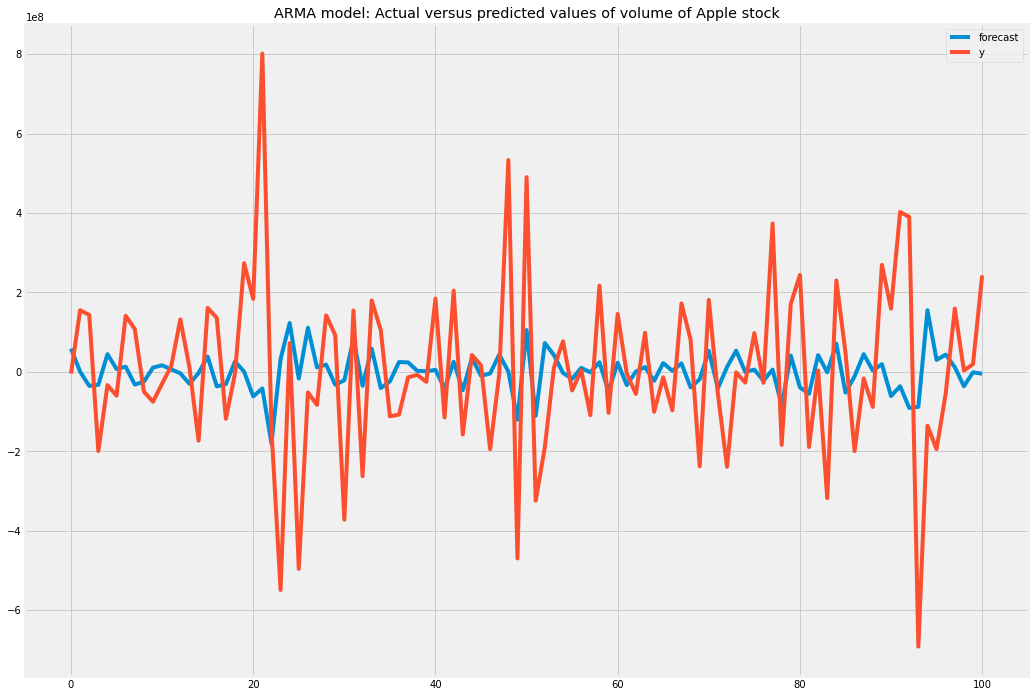

In [ ]:
# Predicting Volume of Apple
volume = ARMA(apple["Volume"].diff().iloc[1:].values, order=(1,0))
res = volume.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of volume of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Volume"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 155393298.30700317.


There are always better models.

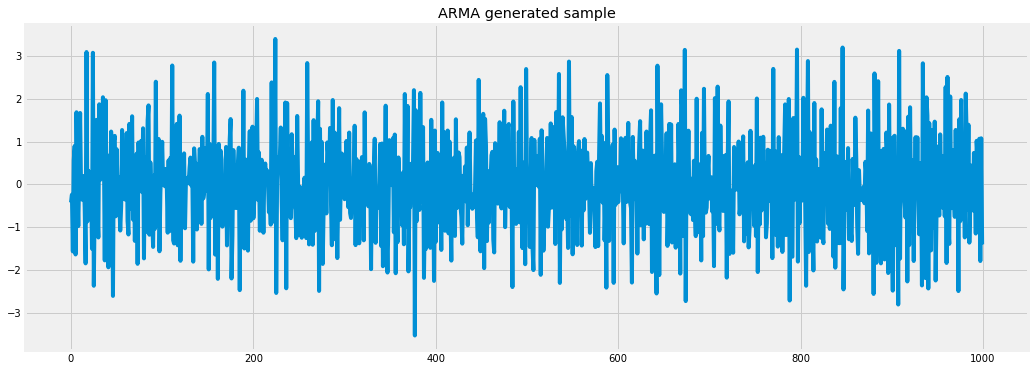

In [ ]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
_ = plt.title('ARMA generated sample')
plt.plot(sim1)

## Forecasting the simulated MA model

In [ ]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

NameError: name 'sim1' is not defined

## Prediction using MA models

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(0, 3)   Log Likelihood               -4183.393
Method:                       css-mle   S.D. of innovations              0.670
Date:                Mon, 02 May 2022   AIC                           8376.785
Time:                        12:57:34   BIC                           8408.390
Sample:                             0   HQIC                          8387.973
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0153      0.010      1.524      0.128      -0.004       0.035
ma.L1.y       -0.0822      0.016     -5.271      0.000      -0.113      -0.052
ma.L2.y       -0.0003      0.016     -0.016      0.9

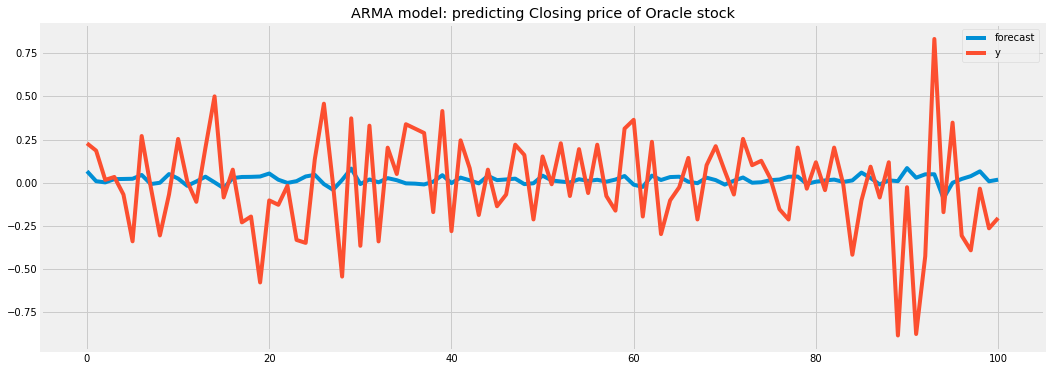

In [ ]:
# Forecasting and predicting Closing price of Oracle
model = ARMA(oracle["Close"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Closing price of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.2934590312163215.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(0, 3)   Log Likelihood              -72363.745
Method:                       css-mle   S.D. of innovations       10766271.348
Date:                Mon, 02 May 2022   AIC                         144737.491
Time:                        12:57:51   BIC                         144769.095
Sample:                             0   HQIC                        144748.678
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.171e+04    1.8e+04     -0.652      0.515   -4.69e+04    2.35e+04
ma.L1.y       -0.5496      0.016    -35.305      0.000      -0.580      -0.519
ma.L2.y       -0.2233      0.019    -11.940      0.0

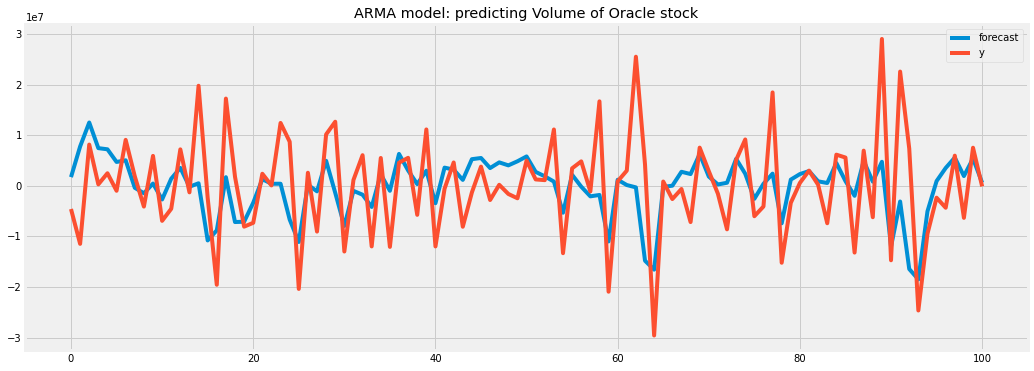

In [ ]:
# Forecasting and predicting Volume of Oracle
model = ARMA(oracle["Volume"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 13787084.00222689.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(0, 3)   Log Likelihood               -5918.384
Method:                       css-mle   S.D. of innovations              1.022
Date:                Mon, 02 May 2022   AIC                          11846.768
Time:                        12:57:56   BIC                          11878.372
Sample:                             0   HQIC                         11857.956
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0379      0.015      2.581      0.010       0.009       0.067
ma.L1.y       -0.0514      0.016     -3.282      0.001      -0.082      -0.021
ma.L2.y       -0.0092      0.016     -0.586      0.5

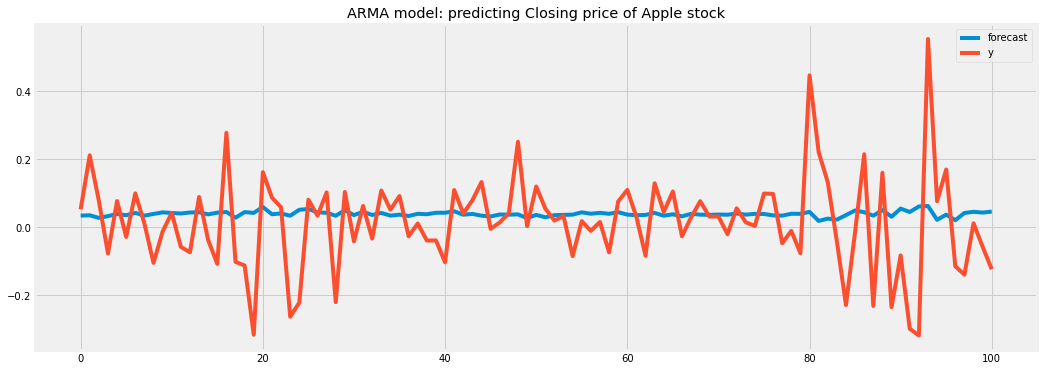

In [ ]:
# Forecasting and predicting Closing price of Apple
model = ARMA(apple["Close"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Closing price of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.14531950135616706.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(0, 3)   Log Likelihood              -83736.552
Method:                       css-mle   S.D. of innovations      171445333.914
Date:                Mon, 02 May 2022   AIC                         167483.104
Time:                        12:58:05   BIC                         167514.708
Sample:                             0   HQIC                        167494.291
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.644e+05   5.42e+05     -0.304      0.761   -1.23e+06    8.97e+05
ma.L1.y       -0.4132      0.015    -26.770      0.000      -0.443      -0.383
ma.L2.y       -0.2618      0.017    -15.634      0.0

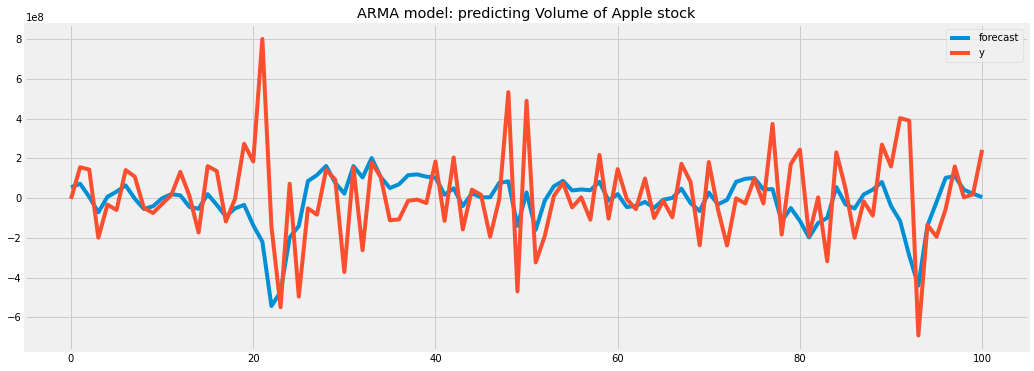

In [ ]:
# Forecasting and predicting Volume of Apple
model = ARMA(apple["Volume"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 292355032.57577777.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(3, 3)   Log Likelihood               -4169.936
Method:                       css-mle   S.D. of innovations              0.668
Date:                Mon, 02 May 2022   AIC                           8355.871
Time:                        12:58:18   BIC                           8406.439
Sample:                             0   HQIC                          8373.772
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0154      0.010      1.481      0.139      -0.005       0.036
ar.L1.y       -0.2088      0.136     -1.535      0.125      -0.475       0.058
ar.L2.y        0.0466      0.089      0.524      0.6

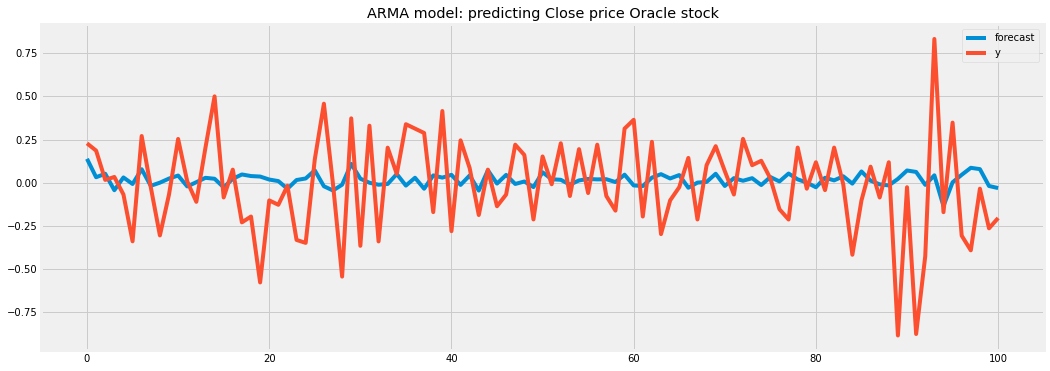

In [ ]:
# Forecasting and predicting Closing price of Oracle stock
model = ARMA(oracle["Close"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Close price Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.28899362619563107.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(3, 3)   Log Likelihood              -72315.945
Method:                       css-mle   S.D. of innovations       10640454.198
Date:                Mon, 02 May 2022   AIC                         144647.890
Time:                        12:58:35   BIC                         144698.457
Sample:                             0   HQIC                        144665.790
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.171e+04   4783.606     -2.449      0.014   -2.11e+04   -2337.227
ar.L1.y        0.2158      0.074      2.930      0.003       0.071       0.360
ar.L2.y        0.8969      0.033     27.041      0.0

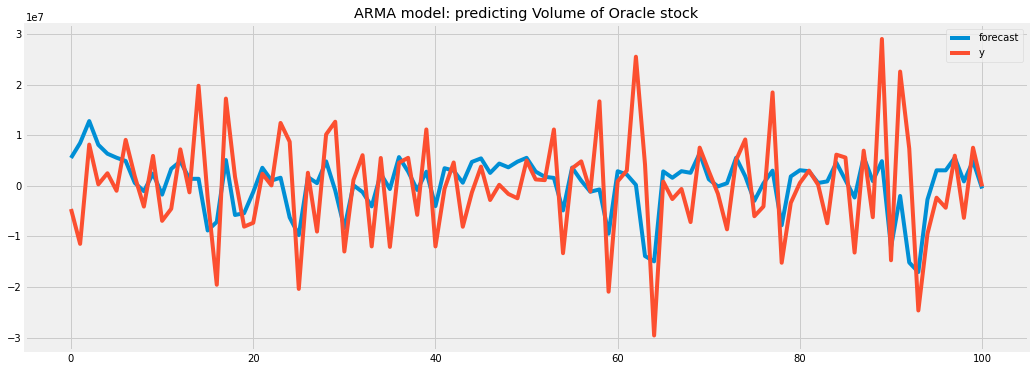

In [ ]:
# Forecasting and predicting Oracle stock volume
model = ARMA(oracle["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 13892260.95479857.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4109
Model:                     ARMA(3, 3)   Log Likelihood              -83717.658
Method:                       css-mle   S.D. of innovations      170590759.008
Date:                Mon, 02 May 2022   AIC                         167451.317
Time:                        12:58:46   BIC                         167501.884
Sample:                             0   HQIC                        167469.217
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.644e+05   1.19e+05     -1.380      0.168   -3.98e+05    6.92e+04
ar.L1.y        0.4128      0.030     13.734      0.000       0.354       0.472
ar.L2.y        0.9700      0.008    125.717      0.0

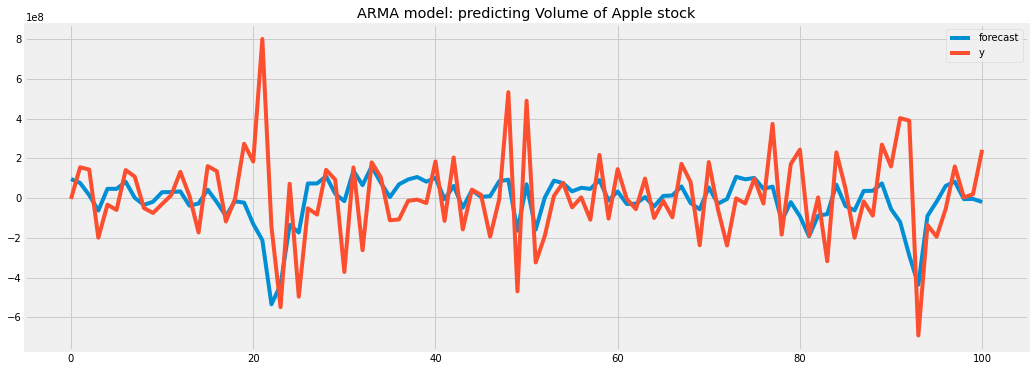

In [ ]:
# Forecasting and predicting Apple stock volume
model = ARMA(apple["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: predicting Volume of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 295465907.6314776.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4108
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4772.959
Method:                       css-mle   S.D. of innovations              0.773
Date:                Mon, 02 May 2022   AIC                           9553.918
Time:                        12:58:58   BIC                           9579.200
Sample:                             1   HQIC                          9562.868
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.006     -0.037      0.970      -0.011       0.011
ar.L1.D.y     -0.7375      0.014    -50.969      0.000      -0.766      -0.709
ar.L2.D.y     -0.3794      0.014    -26.225      0.0

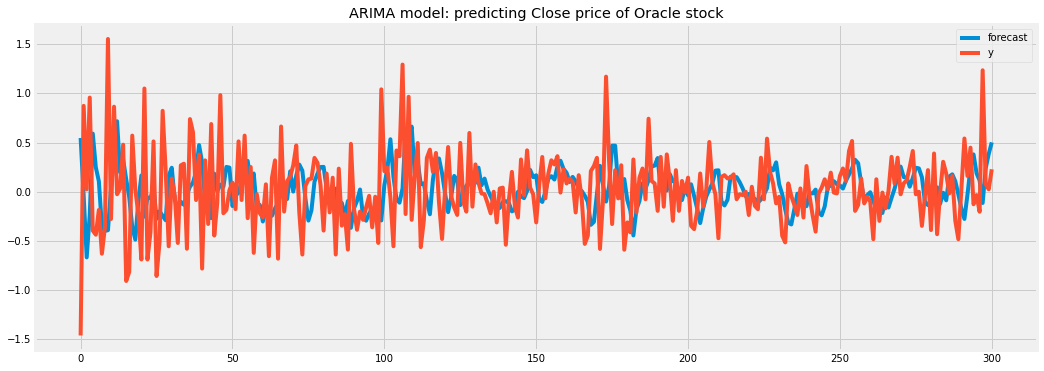

In [ ]:
# Predicting the close price of Oracle stock
rcParams['figure.figsize'] = 16, 6
model = ARIMA(oracle["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Close price of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.7443775933104555.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4108
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -73641.780
Method:                       css-mle   S.D. of innovations       14759398.829
Date:                Mon, 02 May 2022   AIC                         147291.559
Time:                        12:59:05   BIC                         147316.842
Sample:                             1   HQIC                        147300.509
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        347.8578   1.01e+05      0.003      0.997   -1.98e+05    1.99e+05
ar.L1.D.y     -0.8316      0.014    -59.396      0.000      -0.859      -0.804
ar.L2.D.y     -0.4416      0.014    -31.532      0.0

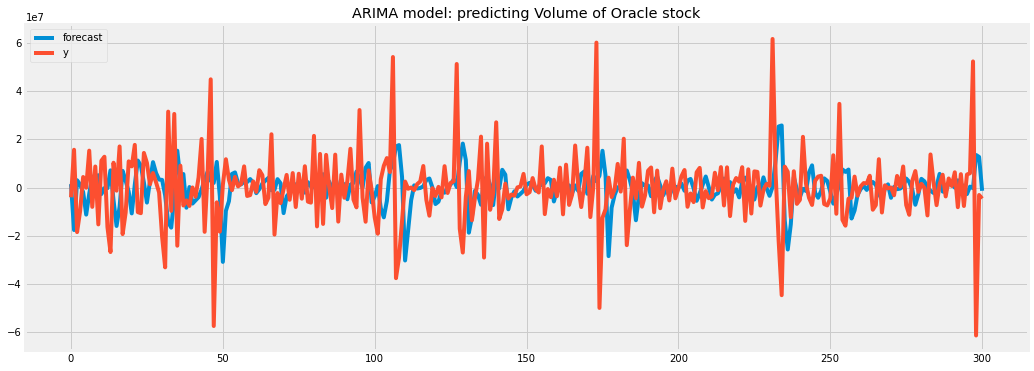

In [ ]:
# Predicting the Oracle stock volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(oracle["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Volume of Oracle stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(oracle["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 29308257.690232333.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4108
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6553.159
Method:                       css-mle   S.D. of innovations              1.193
Date:                Mon, 02 May 2022   AIC                          13114.319
Time:                        12:59:20   BIC                          13139.601
Sample:                             1   HQIC                         13123.268
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.009     -0.015      0.988      -0.018       0.018
ar.L1.D.y     -0.6963      0.015    -47.087      0.000      -0.725      -0.667
ar.L2.D.y     -0.3395      0.015    -22.890      0.0

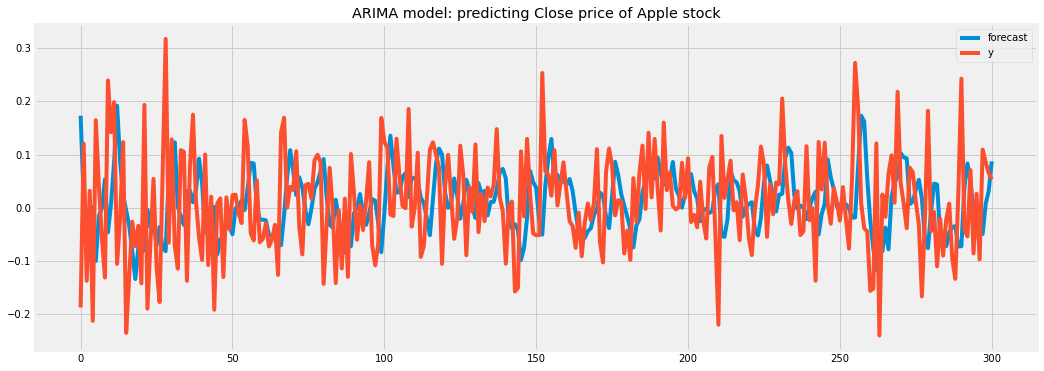

In [ ]:
# Predicting the Close price of Apple stocks
rcParams['figure.figsize'] = 16, 6
model = ARIMA(apple["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Close price of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.16992960123024858.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4108
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -85013.521
Method:                       css-mle   S.D. of innovations      235120269.598
Date:                Mon, 02 May 2022   AIC                         170035.041
Time:                        12:59:27   BIC                         170060.324
Sample:                             1   HQIC                        170043.991
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.601e+04   1.73e+06      0.027      0.979   -3.35e+06    3.44e+06
ar.L1.D.y     -0.7251      0.014    -50.504      0.000      -0.753      -0.697
ar.L2.D.y     -0.3913      0.014    -27.252      0.0

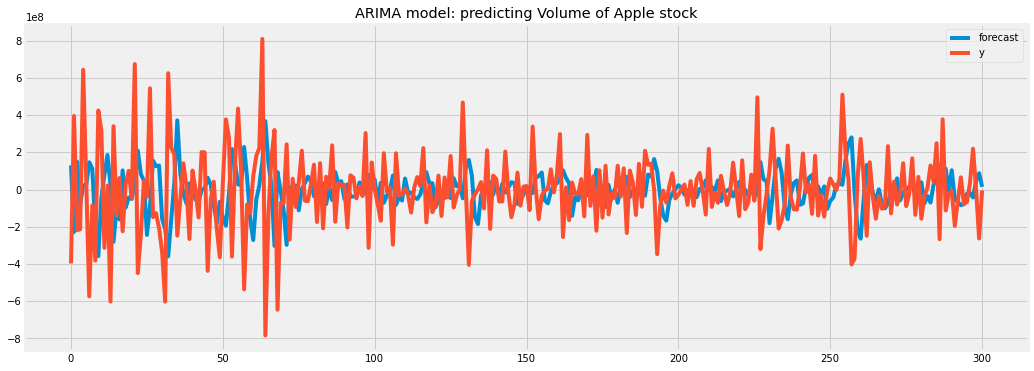

In [ ]:
# Predicting the Apple stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(apple["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Volume of Apple stock')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(apple["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 393913564.6183435.


Taking the slight lag into account, this is a fine model.

                           Statespace Model Results                           
Dep. Variable:     ['Close', 'Close']   No. Observations:                 4109
Model:                     VARMA(2,1)   Log Likelihood               -9717.587
                          + intercept   AIC                          19469.175
Date:                Mon, 02 May 2022   BIC                          19576.631
Time:                        13:00:12   HQIC                         19507.213
Sample:                             0                                         
                               - 4109                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.12, 0.00   Jarque-Bera (JB):   529519.28, 81726.08
Prob(Q):                        0.73, 0.99   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):        8.51, 68.06   Skew:                        1.53, 0.41
Prob(H) (two-sided):            0.

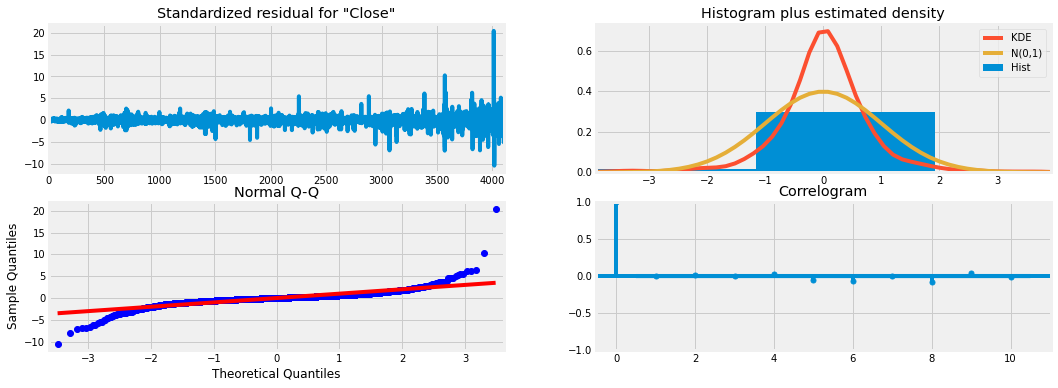

In [ ]:
# Predicting closing price of Oracle and Apple
train_sample = pd.concat([oracle["Close"].diff().iloc[1:], apple["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

                            Statespace Model Results                            
Dep. Variable:     ['Volume', 'Volume']   No. Observations:                 4109
Model:                       VARMA(2,1)   Log Likelihood             -156015.071
                            + intercept   AIC                         312064.143
Date:                  Mon, 02 May 2022   BIC                         312171.599
Time:                          13:00:30   HQIC                        312102.181
Sample:                               0                                         
                                 - 4109                                         
Covariance Type:                    opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):   240875.66, 123794.28
Prob(Q):                        0.90, 1.00   Prob(JB):                     0.00, 0.00
Heteroskedasticity (H):         0.20, 0.02   Skew:                         4.03, 2.88
Prob(H) (two-

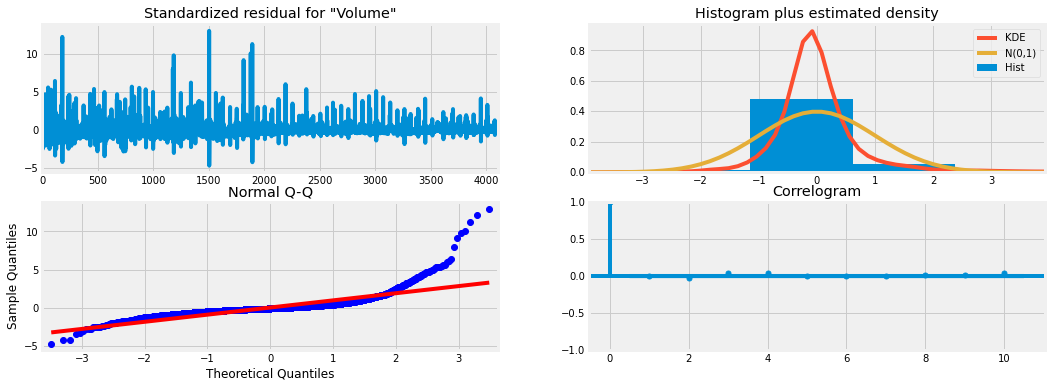

In [ ]:
# Predicting Volume of Oracle and Apple
train_sample = pd.concat([oracle["Volume"].diff().iloc[1:], apple["Volume"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4109
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -4170.216
Date:                Mon, 02 May 2022   AIC                           8360.431
Time:                        13:00:50   BIC                           8423.628
Sample:                             0   HQIC                          8382.804
                               - 4109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0248      0.017      1.455      0.146      -0.009       0.058
ar.L1          0.0999      0.145      0.687      0.492      -0.185       0.385
ar.L2          0.0694      0.025      2.823      0.0

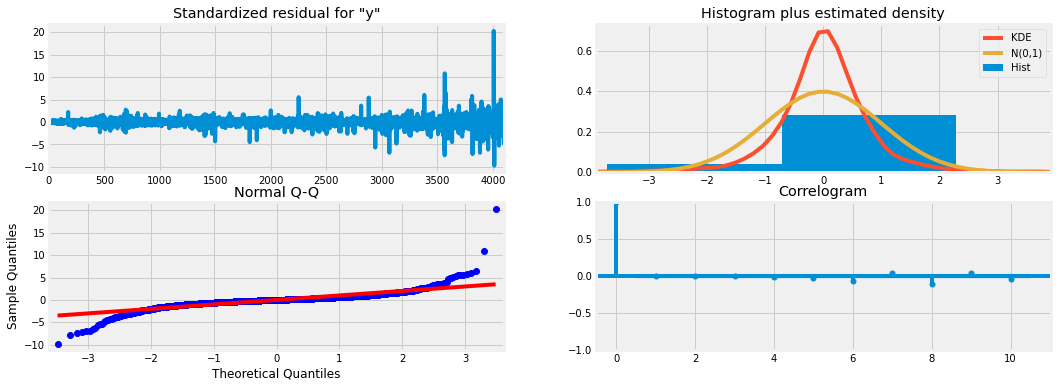

In [ ]:
# Predicting closing price of Oracle'
train_sample = oracle["Close"].diff().iloc[1:].values

model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

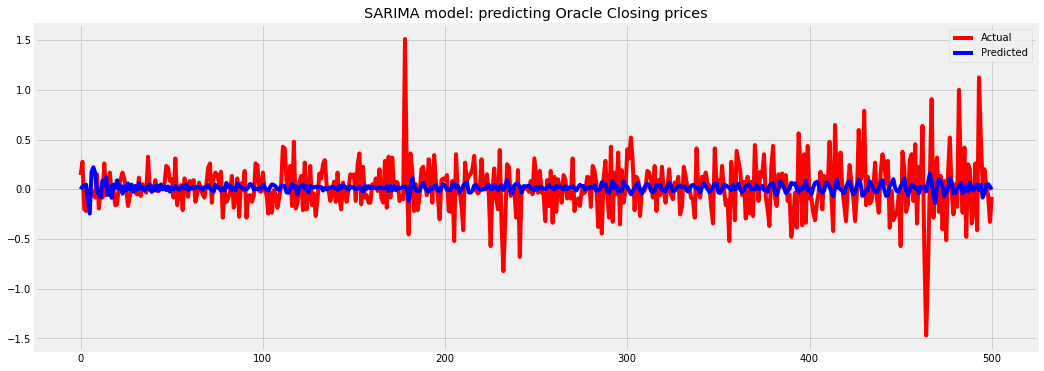

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting Oracle Closing prices')
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4109
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -72495.735
Date:                Mon, 02 May 2022   AIC                         145011.470
Time:                        13:01:06   BIC                         145074.667
Sample:                             0   HQIC                        145033.843
                               - 4109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.798e+04   6.17e-06  -6.15e+09      0.000    -3.8e+04    -3.8e+04
ar.L1         -0.3159      0.258     -1.223      0.221      -0.822       0.190
ar.L2          0.0809      0.244      0.332      0.7

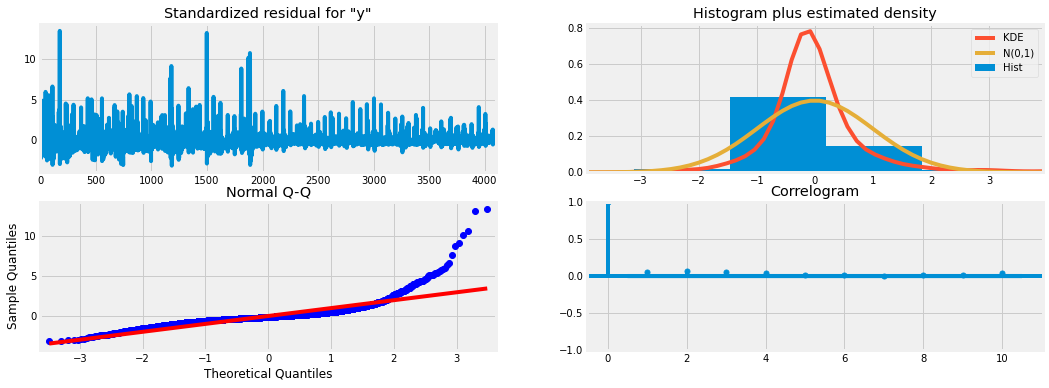

In [ ]:
# Predicting Volume of Oracle'
train_sample = oracle["Volume"].diff().iloc[1:].values

model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

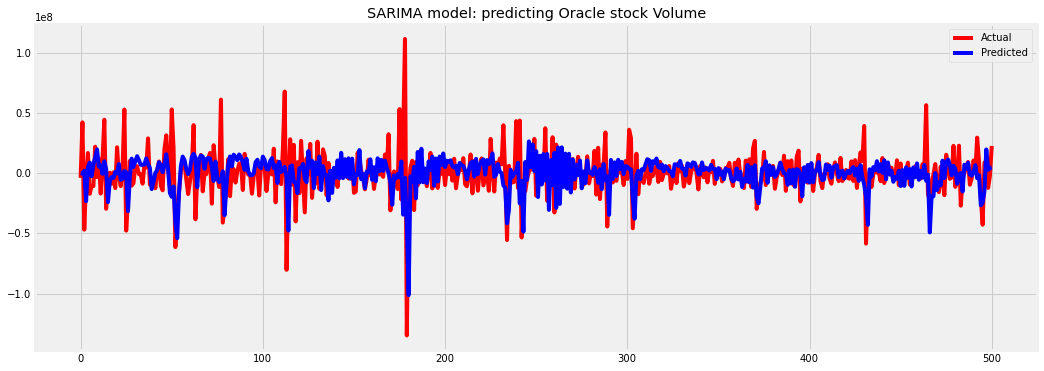

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting Oracle stock Volume')
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4109
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -5868.115
Date:                Mon, 02 May 2022   AIC                          11756.231
Time:                        13:01:19   BIC                          11819.428
Sample:                             0   HQIC                         11778.603
                               - 4109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1627      0.070      2.335      0.020       0.026       0.299
ar.L1         -1.3153      0.138     -9.566      0.000      -1.585      -1.046
ar.L2         -0.6245      0.219     -2.848      0.0

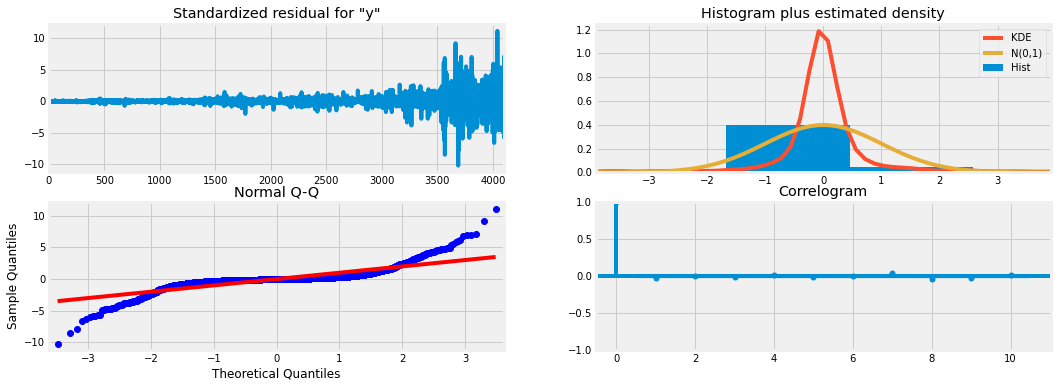

In [ ]:
train_sample = apple["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

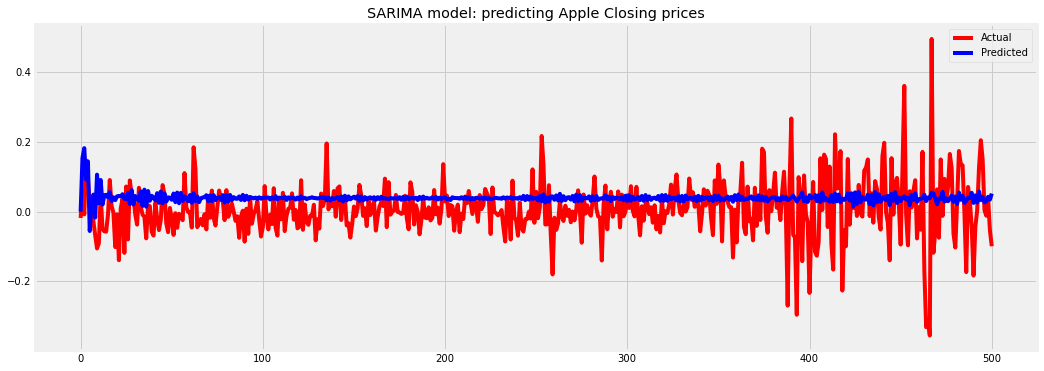

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting Apple Closing prices')
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4109
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -83583.526
Date:                Mon, 02 May 2022   AIC                         167187.053
Time:                        13:01:28   BIC                         167250.250
Sample:                             0   HQIC                        167209.425
                               - 4109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8.758e+05   4.63e-07  -1.89e+12      0.000   -8.76e+05   -8.76e+05
ar.L1          0.4480      0.264      1.698      0.089      -0.069       0.965
ar.L2          0.0190      0.342      0.056      0.9

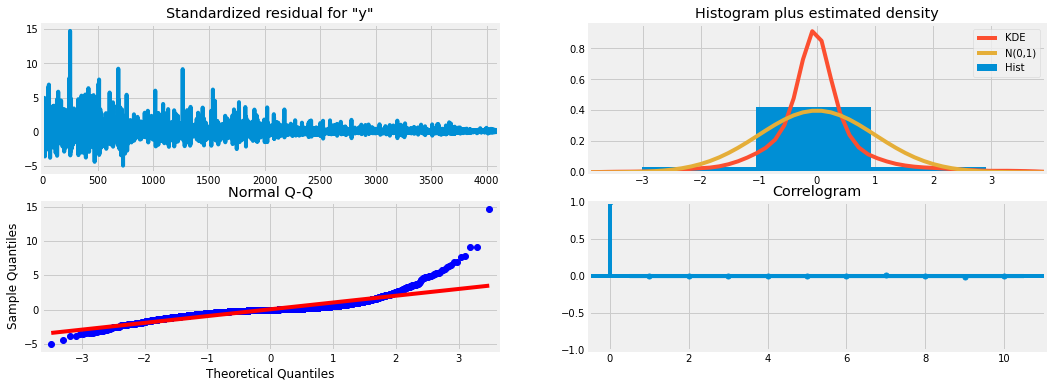

In [ ]:
train_sample = apple["Volume"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

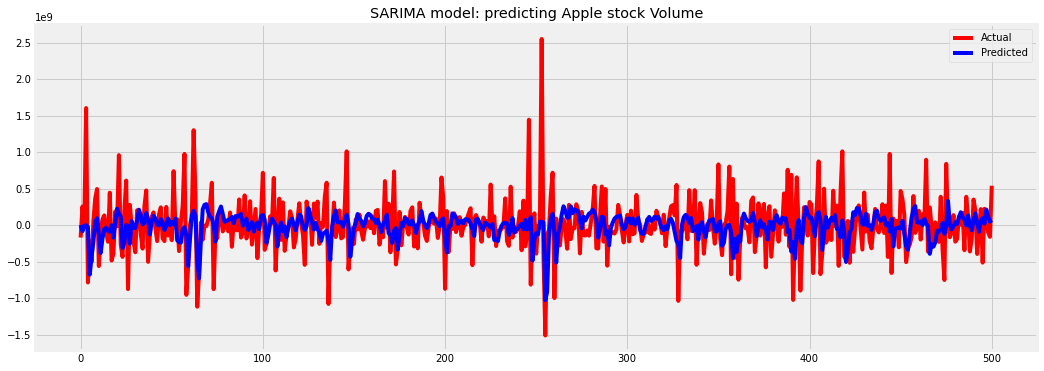

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: predicting Apple stock Volume')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 4109
Model:                    local level   Log Likelihood               -4204.195
Date:                Mon, 02 May 2022   AIC                           8412.390
Time:                        13:01:30   BIC                           8425.031
Sample:                             0   HQIC                          8416.865
                               - 4109                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.4524      0.002    224.658      0.000       0.448       0.456
sigma2.level      2.501e-11   2.11e-07      0.000      1.000   -4.14e-07    4.14e-07
Ljung-Box (L1) (Q):         

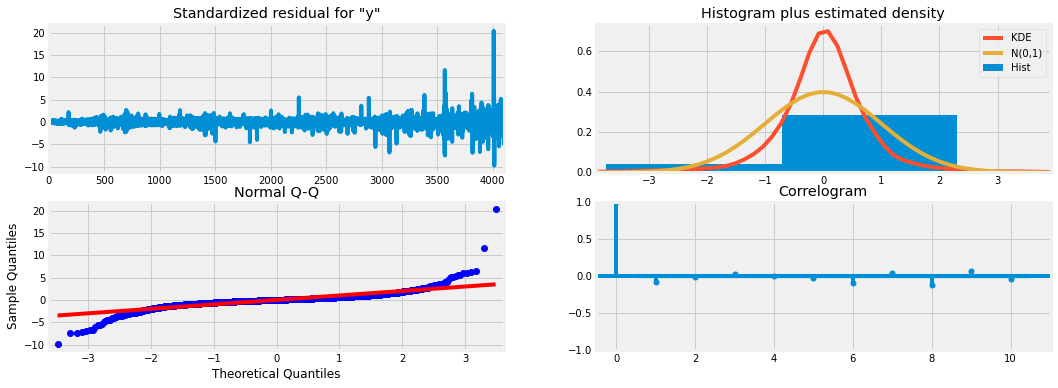

In [ ]:
# Predicting closing price of Oracle'
train_sample = oracle["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

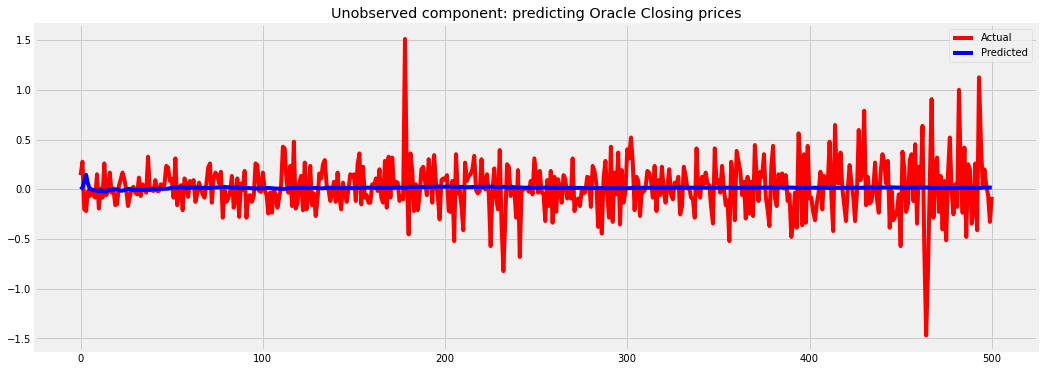

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting Oracle Closing prices')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 4109
Model:                    local level   Log Likelihood              -72995.473
Date:                Mon, 02 May 2022   AIC                         145994.945
Time:                        13:01:31   BIC                         146007.587
Sample:                             0   HQIC                        145999.420
                               - 4109                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.529e+14   8.88e+11    172.093      0.000    1.51e+14    1.55e+14
sigma2.level      1.945e+11   5.04e+10      3.858      0.000    9.57e+10    2.93e+11
Ljung-Box (L1) (Q):         

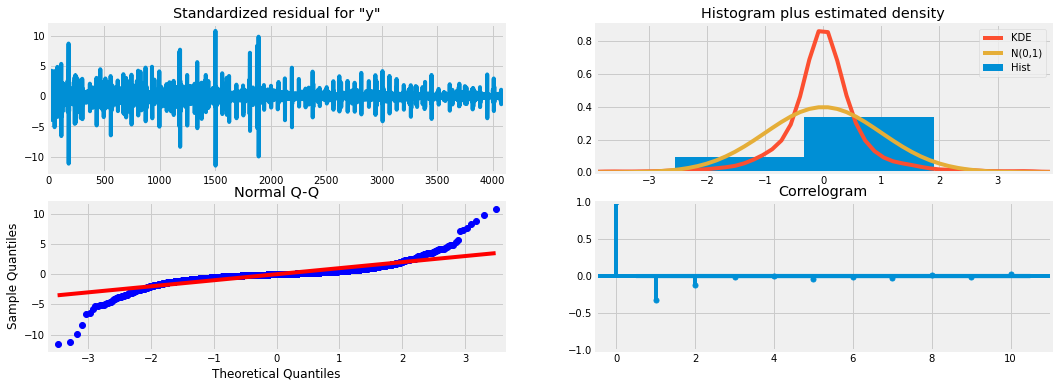

In [ ]:
# Predicting Volume of Oracle'
train_sample = oracle["Volume"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

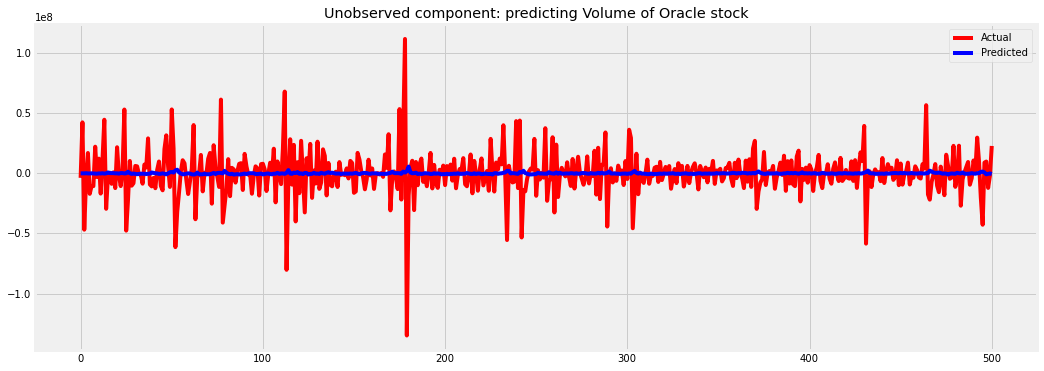

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting Volume of Oracle stock')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 4109
Model:                    local level   Log Likelihood               -5926.535
Date:                Mon, 02 May 2022   AIC                          11857.070
Time:                        13:01:32   BIC                          11869.712
Sample:                             0   HQIC                         11861.545
                               - 4109                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     1.0457      0.007    155.349      0.000       1.033       1.059
sigma2.level      1.775e-06   1.09e-06      1.635      0.102   -3.53e-07     3.9e-06
Ljung-Box (L1) (Q):         

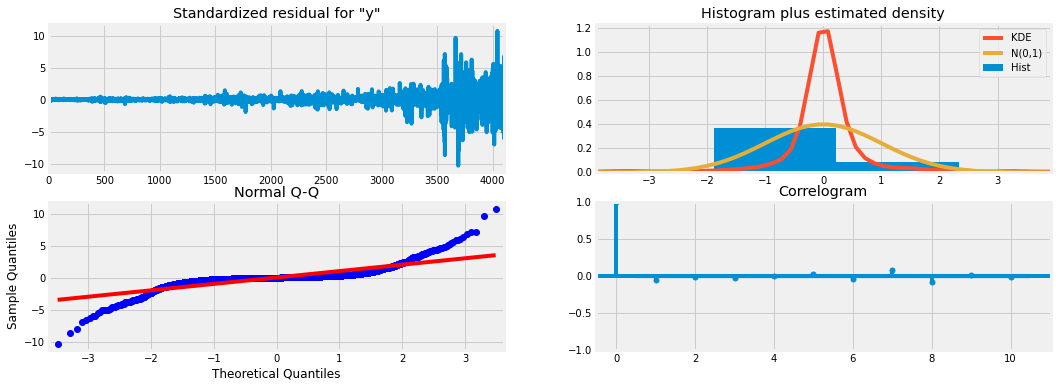

In [ ]:
# Predicting closing price of Apple'
train_sample = apple["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

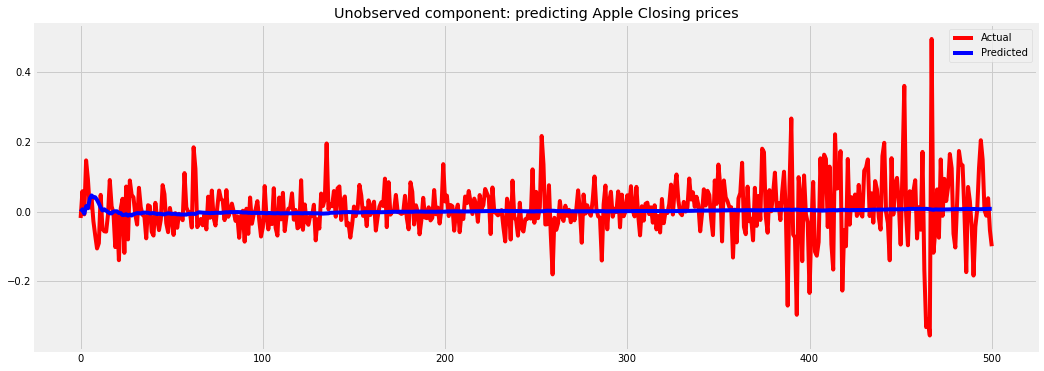

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting Apple Closing prices')
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 4109
Model:                    local level   Log Likelihood              -84255.135
Date:                Mon, 02 May 2022   AIC                         168514.269
Time:                        13:01:33   BIC                         168526.911
Sample:                             0   HQIC                        168518.744
                               - 4109                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  3.633e+16   2.61e+14    139.413      0.000    3.58e+16    3.68e+16
sigma2.level      7.796e+13   2.06e+13      3.781      0.000    3.75e+13    1.18e+14
Ljung-Box (L1) (Q):         

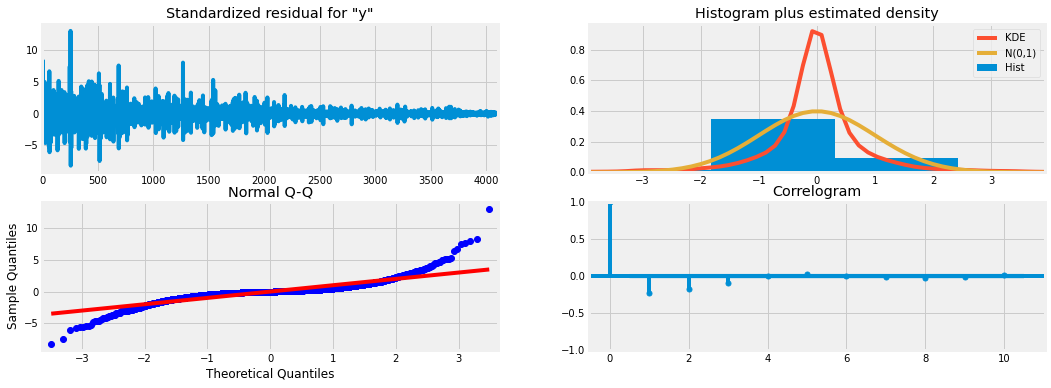

In [ ]:
# Predicting Volume of Apple'
train_sample = apple["Volume"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

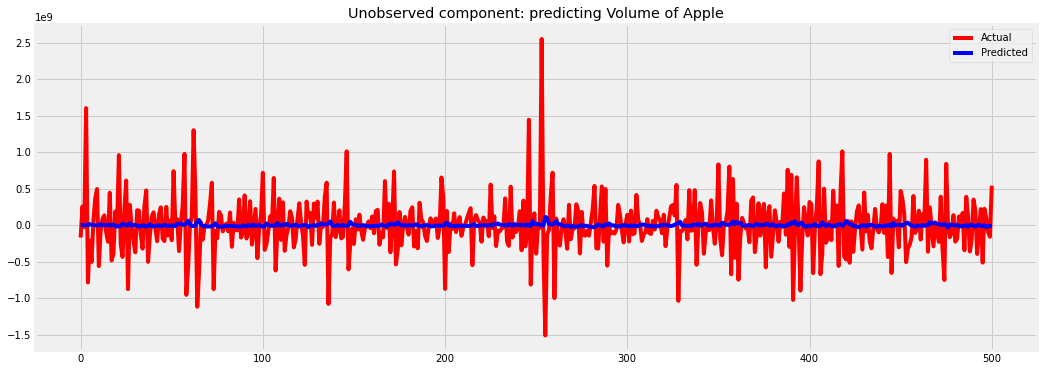

In [ ]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Unobserved component: predicting Volume of Apple')
plt.show()

                                   Statespace Model Results                                  
Dep. Variable:                    ['Close', 'Close']   No. Observations:                 4109
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood               -9747.443
Date:                               Mon, 02 May 2022   AIC                          19506.887
Time:                                       13:01:40   BIC                          19544.812
Sample:                                            0   HQIC                         19520.312
                                              - 4109                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):             0.28, 3.24   Jarque-Bera (JB):   547229.59, 83274.96
Prob(Q):                        0.60, 0.07   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):        8.60, 75.24   Skew:                        1.59

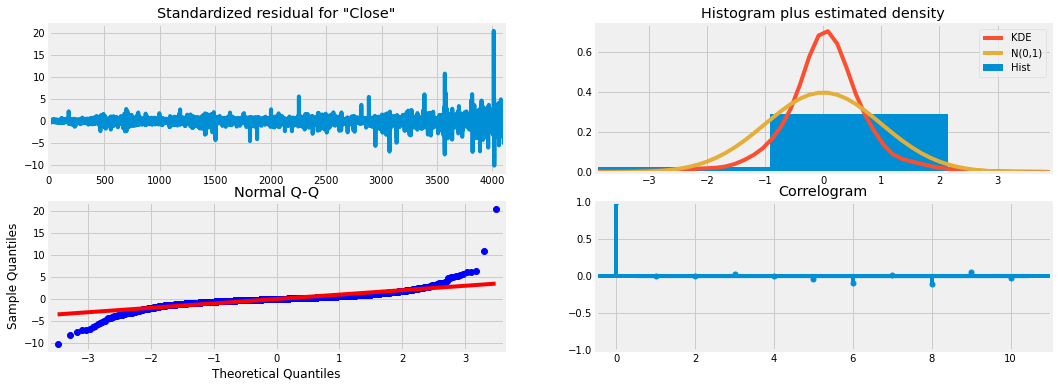

In [ ]:
# Predicting closing price of Oracle and Apple
train_sample = pd.concat([oracle["Close"].diff().iloc[1:], apple["Close"].diff().iloc[1:]],axis=1)
train_sample = train_sample.fillna(0.0) # Ideally we should not need to do this
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
predicted_result.columns=['Oracle Prediction', 'Apple Prediction']

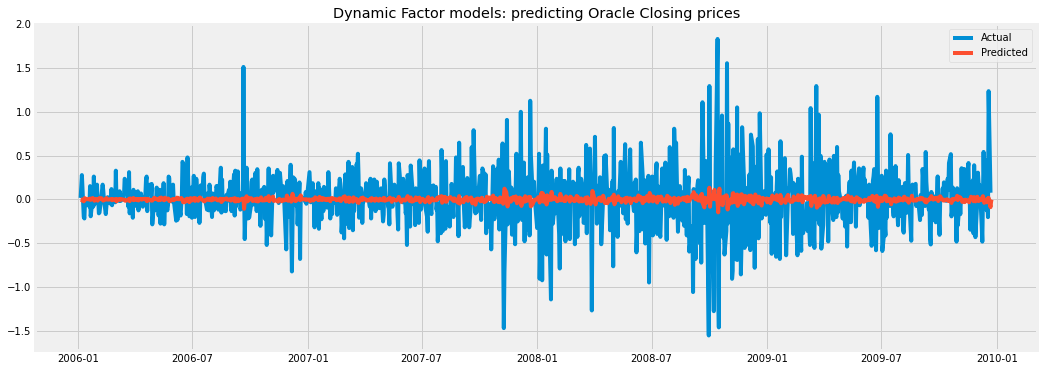

In [ ]:
plt.plot(oracle["Close"].diff().iloc[1:1000])
plt.plot(predicted_result['Oracle Prediction'])
plt.legend(['Actual','Predicted'])
plt.title('Dynamic Factor models: predicting Oracle Closing prices')
plt.show()

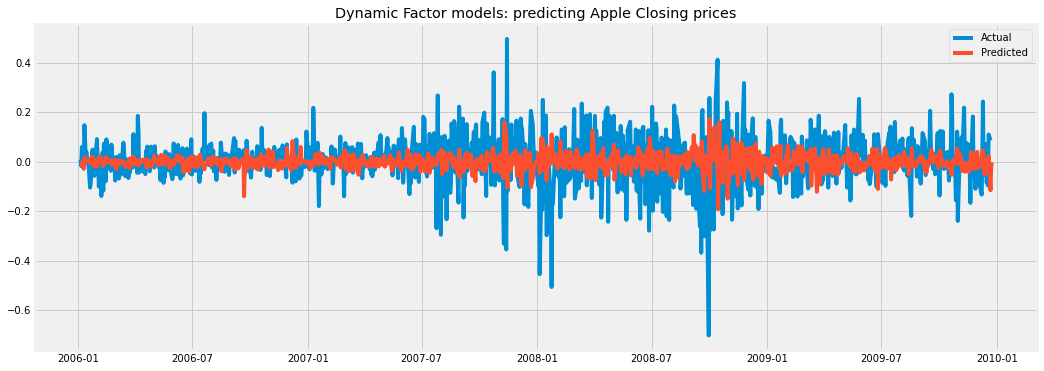

In [ ]:
plt.plot(apple["Close"].diff().iloc[1:1000])
plt.plot(predicted_result['Apple Prediction'])
plt.legend(['Actual','Predicted'])
plt.title('Dynamic Factor models: predicting Apple Closing prices')
plt.show()

                                   Statespace Model Results                                  
Dep. Variable:                  ['Volume', 'Volume']   No. Observations:                 4109
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood             -172140.004
Date:                               Mon, 02 May 2022   AIC                         344292.008
Time:                                       13:01:42   BIC                         344329.934
Sample:                                            0   HQIC                        344305.433
                                              - 4109                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):         331.37, 311.94   Jarque-Bera (JB):   117827.06, 48046.84
Prob(Q):                        0.00, 0.00   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):         0.19, 0.09   Skew:                        0.48

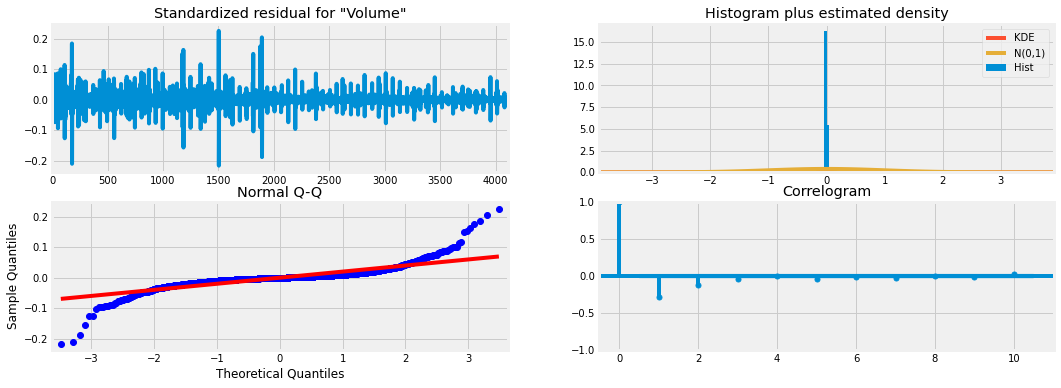

In [ ]:
# Predicting Volume of Oracle and Apple
train_sample = pd.concat([oracle["Volume"].diff().iloc[1:], apple["Volume"].diff().iloc[1:]],axis=1)
train_sample = train_sample.fillna(0.0) # Ideally we should not need to do this
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=1000, disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
predicted_result.columns=['Oracle Prediction', 'Apple Prediction']

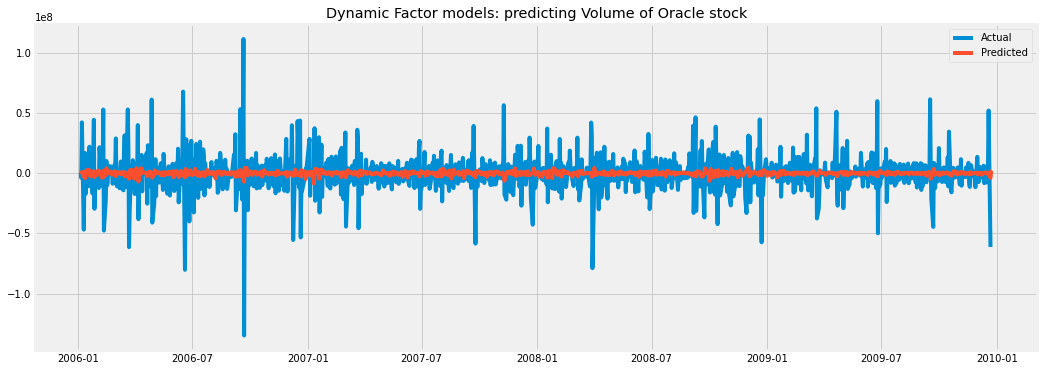

In [ ]:
plt.plot(oracle["Volume"].diff().iloc[1:1000])
plt.plot(predicted_result['Oracle Prediction'])
plt.legend(['Actual','Predicted'])
plt.title('Dynamic Factor models: predicting Volume of Oracle stock')
plt.show()

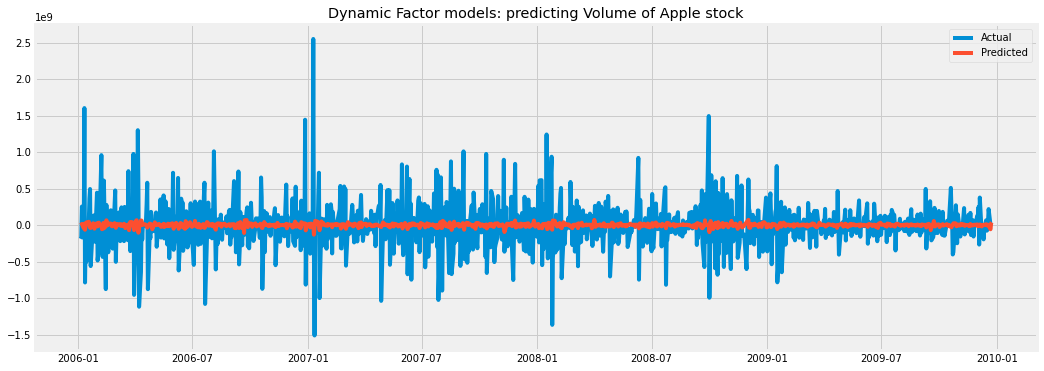

In [ ]:
plt.plot(apple["Volume"].diff().iloc[1:1000])
plt.plot(predicted_result['Apple Prediction'])
plt.legend(['Actual','Predicted'])
plt.title('Dynamic Factor models: predicting Volume of Apple stock')
plt.show()